# Анализ кластеров за 2016 год

In [106]:
import json
import numpy as np
from itertools import groupby
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO

from IPython.display import display

%matplotlib inline

In [2]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [3]:
def filter_words(text):
    words_list = text.split()
    newWords = [x for x in words_list if len(x) > 3]
    return " ".join(newWords)

# Загрузка новостей

In [4]:
news = []
with open('/data/kasandra/year/2016.all.normalized.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
news_map = {n.id: n for n in news}

# Удаление стоп-слов

In [5]:
words = []
for n in news:
    words.extend(n.content.split())
counts = Counter(words)
one_time = [k for k, v in dict(counts).items() if v == 1]
print("total words: %s" % (len(words) - len(one_time)))

total words: 19048075


In [6]:
one_time_words = set(one_time)

# Загрузка результатов кластеризации

In [7]:
news_labels = {}
with open('/data/kasandra/year/result/2016.300.kmeans.json', encoding="utf8") as f:
    news_labels = json.loads(f.read())

In [8]:
cluster_news = {}
for n_id, label in news_labels.items():
    if label in cluster_news:
        n_list = cluster_news[label]
        n_list.append(news_map[n_id])
    else:
        n_list = []
        n_list.append(news_map[n_id])
        cluster_news[label] = n_list

# Векторизация

In [9]:
news_constent = [filter_words(x.content) for x in news]

In [10]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), stop_words=one_time_words,
                                   max_df=0.5, min_df=2, norm='l2')

tfidf_matrix = tfidf_vectorizer.fit_transform(news_constent)
print("vocabulary size: %s" % len(tfidf_vectorizer.vocabulary_))

vocabulary size: 95475


# Количество новостей в кластерах

In [26]:
counts = Counter(news_labels.values())
counts.most_common(300)

[(21, 7121),
 (47, 1974),
 (38, 1368),
 (102, 1222),
 (67, 1144),
 (280, 1142),
 (10, 1024),
 (238, 966),
 (157, 950),
 (24, 922),
 (164, 891),
 (214, 876),
 (95, 874),
 (253, 874),
 (207, 849),
 (276, 823),
 (211, 775),
 (69, 759),
 (28, 754),
 (261, 737),
 (54, 723),
 (267, 712),
 (188, 708),
 (137, 705),
 (16, 694),
 (44, 688),
 (7, 681),
 (297, 675),
 (184, 654),
 (5, 654),
 (160, 619),
 (233, 616),
 (55, 614),
 (25, 612),
 (204, 603),
 (29, 589),
 (230, 571),
 (77, 550),
 (88, 548),
 (167, 544),
 (130, 544),
 (8, 529),
 (275, 518),
 (281, 514),
 (117, 511),
 (176, 510),
 (26, 508),
 (295, 505),
 (203, 504),
 (103, 500),
 (243, 497),
 (136, 493),
 (134, 491),
 (11, 486),
 (123, 483),
 (116, 481),
 (241, 474),
 (41, 471),
 (58, 469),
 (51, 465),
 (149, 455),
 (225, 451),
 (118, 450),
 (40, 447),
 (229, 444),
 (61, 439),
 (146, 437),
 (57, 434),
 (60, 434),
 (145, 428),
 (53, 422),
 (50, 422),
 (266, 401),
 (80, 399),
 (257, 393),
 (18, 389),
 (59, 383),
 (223, 380),
 (101, 379),
 (2

In [12]:
titles = [n.title for n in cluster_news[74]]
titles[:10]

['Белорусские спортсмены пронесут российский флаг во время открытия Паралимпиады',
 'Белорусские паралимпийцы пронесли флаг России на открытии Игр в Рио',
 'МПК устанавливает личность белоруса, вынесшего флаг России на "Маракане"',
 'IPC расследует вынос флага России белорусами на открытии Игр',
 'МПК заинтересовался личностью пронесшего флаг России белорусского паралимпийца',
 'IPC проведет расследование в отношении белорусов за вынос российского флага',
 'IPC опознал белоруса, несшего российский флаг на открытии Паралимпиады',
 'Личность пронесшего флаг России на открытии Паралимпиады белоруса установлена',
 'Паралимпийцев из Белоруссии накажут за вынос российского флага',
 'Паралимпийский комитет идентифицировал белорусского атлета, пронёсшего флаг РФ']

# Сегментирование кластеров по дням

In [69]:
# 2016
start_year = 1451595600 * 1000
end_year = 1483217999 * 1000 + 1
day_millis = 24 * 60 * 60 * 1000

In [70]:
def segment_news(seg_news):
    segmented_news = {}
    for cur_day in range(start_year, end_year, day_millis):
        cur_news = [n for n in seg_news if n.date >= start_year and n.date <= cur_day]
        segmented_news[cur_day] = cur_news
    return segmented_news

# Вычисление отклонений для кластера

In [82]:
year_centrid = np.array(tfidf_matrix.mean(axis=0))[0]
# year_centrid = np.empty(tfidf_matrix.shape[1])
# year_centrid.fill(1)

In [83]:
def day_cos(day_news):
    cos_news = {}
    for day, d_news in day_news.items():
        if len(d_news) > 0:
            content_day = [filter_words(x.content) for x in d_news]
            tfidf_day = tfidf_vectorizer.transform(content_day)
            day_centroid = np.array(tfidf_day.mean(axis=0))[0]
            cos_news[day] = spatial.distance.cosine(year_centrid, day_centroid)
        else:
            cos_news[day] = 1
    return cos_news

# Отрисовка графика

In [119]:
def plot_cos_centroid(cos_days, start_day, end_day, label):
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)

    x = list(map(lambda d: datetime.datetime.fromtimestamp(int(d)/1000), cos_days.keys()))
    y = list(cos_days.values())

    plt.plot(x, y, label = label)
    plt.legend(loc='upper right')
    plt.gcf().autofmt_xdate(rotation=60)
    display(fig)
    plt.close()

# Вывод N первых новостей из кластера

In [79]:
def print_news(cl_news, n, cl_label):
    print("cluster: %s, %s из %s новостей:" %(cl_label, n, len(cl_news)))
    for nn in cl_news[:n]:
        print("\t %s" % nn.title)

# Отображение сегментов

In [125]:
def compute_for_cluster(cl_news, cluster_number):
    segmented_news = segment_news(cl_news)
    cos_news = day_cos(segmented_news)
    
    print("График для кластера: %s" % (cluster_number))
    plot_cos_centroid(cos_news, start_year, end_year, cluster_number)
    print_news(cl_news, 20, cluster_number)
    print("----------------------")

# Фильтрация кластеров
убираем нулевой кластер и кластеры с маленьким количеством новостей

In [137]:
max_cluster_size = 2000
mix_cluster_size = 490

In [138]:
medium_clusters = {k: v for k, v in cluster_news.items() if len(v) >= mix_cluster_size and len(v) <= max_cluster_size }
print("count clusters: %s" % len(medium_clusters))

count clusters: 52


# Графики

График для кластера: 47


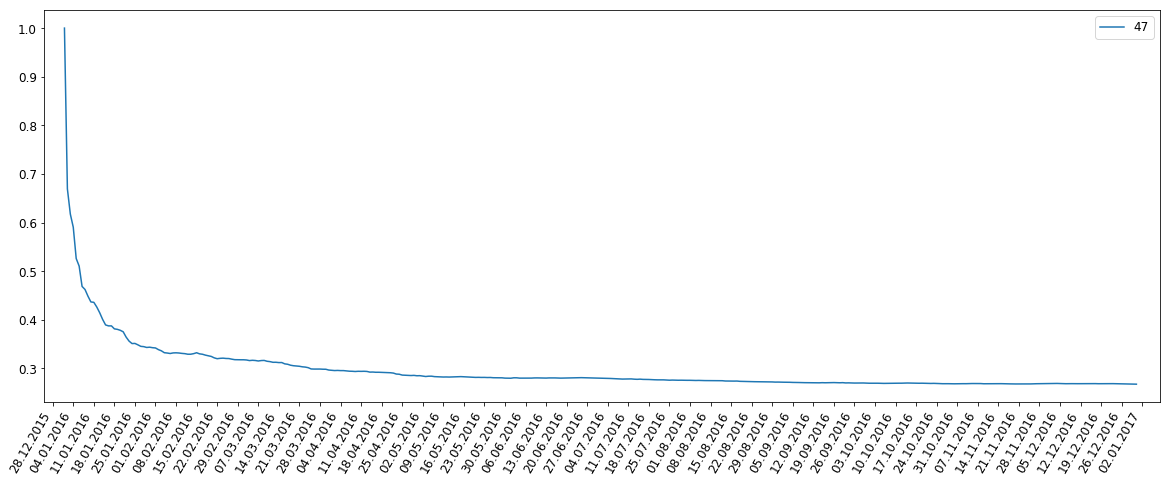

cluster: 47, 20 из 1974 новостей:
	 Уфимка нашла себе мужа под бой курантов
	 10 вещей, которые нужно успеть сделать на каникулах
	 Миллионы россиян от Камчатки до Калининграда встречали новый, 2016 год
	 Которосль, Даманский и другие топонимы
	 Грустный праздник: террористы испортили Европе Новый год
	 Военнослужащие базы "Хмеймим" пишут письма читателям "Комсомолки"
	 Шесть самых странных людей и один кот, удивившие москвичей в прошлом году
	 Погляди-ка, наш главбух! Аж захватывает дух...
	 Подарок Путина изменил жизнь пятиклассницы из Киргизии
	 В Израиле иностранным туристам дают возможность понарошку послужить в армии
	 В Татарстане для мальчишек из неполных семей создали клуб отцов
	 Рубцов погиб, впустив в свою жизнь ведьму
	 Зачем России такие длинные выходные в Новый год
	 От Владивостока до Калининграда в календаре новогодних мероприятий — фестивали, маскарады, шоу
	 Славянский гороскоп на 2016 год: Муравья ждет роман, а Медведя - карьерный рост
	 Пустынька
	 «Играя Рахманино

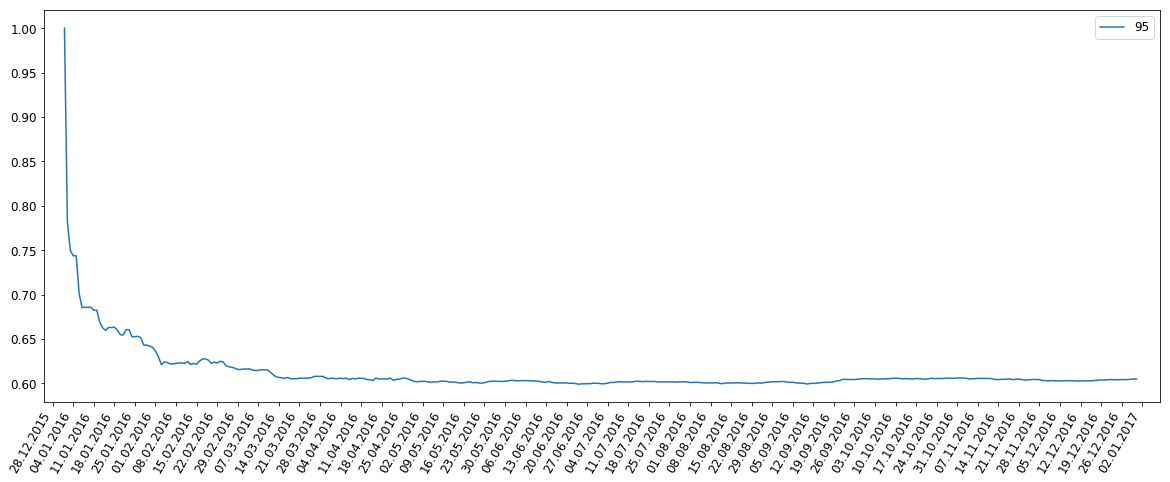

cluster: 95, 20 из 874 новостей:
	 Фильмы на праздники. Выбор Стаса Тыркина
	 Главному символу российского Нового года - 40 лет
	 15 огненных сериальных премьер в год Обезьяны
	 Новогодний дайджест: что посмотреть с 4 по 10 января
	 Шерлоку Холмсу пора в наркодиспансер?
	 «Звездные войны» обогнали «Титаник» по кассовым сборам в США
	 Неудачников Лукашина с Новосельцевым - долой с экранов?
	 Особенности восприятия: почему иностранцы смеются на «Левиафане»
	 Джордж Лукас похвалил советскую цензуру
	 Бейонсе собралась снять фильм о рабыне с гигантскими ягодицами
	 Кино, которое мы посмотрели
	 «Мы все продаем душу подороже — нашелся бы покупатель»
	 Умер "жандарм из Сан-Тропе" - актер Мишель Галабрю
	 Седьмой эпизод «Звездных войн» стал самым кассовым фильмом в Северной Америке
	 «Ди Каприо и Харди были абсолютно бесстрашны»
	 В Ростовской области выставлена на продажу раритетная «Волга» из фильма «Возвращение Будулая»
	 Новые «Звездные войны» вошли в тройку самых кассовых фильмов в истор

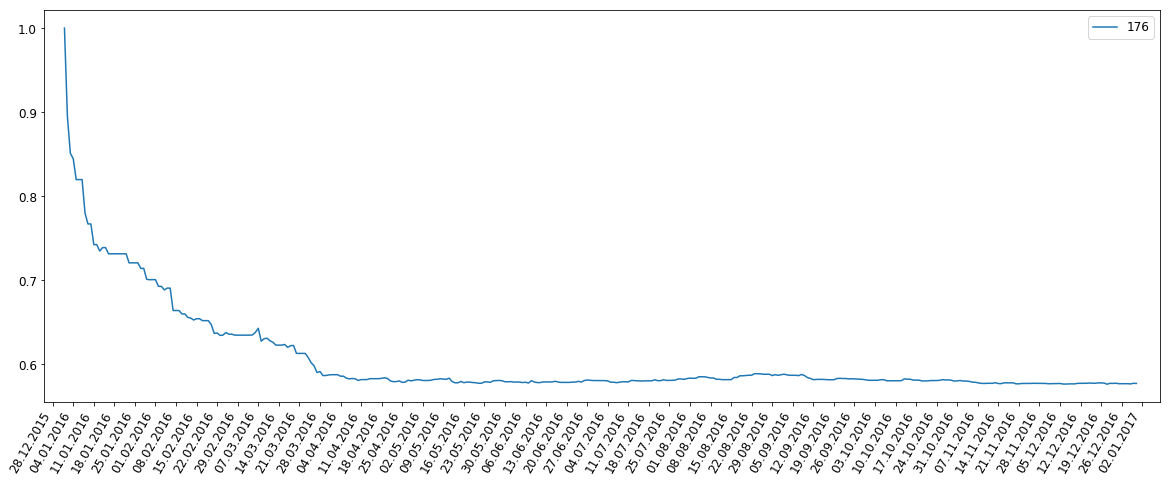

cluster: 176, 20 из 510 новостей:
	 20 самых ярких фотографий встречи Нового года во всем мире
	 История рекламы: от царской России до советской эпохи
	 В Барнаульском зоопарке поженили макак Васю и Масю
	 Блогеры высмеяли фотожабами «появление» Порошенко на обложке The Economist
	 Маленький принц Джордж пошел в детский сад
	 Страшно красивые: 10 самых нелепых результатов пластических операций
	 10 самых "улетных" фото с "Турне четырех трамплинов"
	 10 самых необычных снеговиков
	 Фото Цукерберга с дочкой на приеме у педиатра собрало три миллиона лайков
	 Дизайнеры из Петербурга нашли на карте московского метро рыбу, кролика и логотип-птичку «Комсомолки»
	 Восемь секретов красоты Ренаты Литвиновой
	 «Прощай, египетский верблюд»
	 Отдыхом по кризису
	 Ксении Собчак объяснили, что плоская грудь и узкая кость - не синонимы
	 Неизвестные фото Леонардо ДиКаприо попали в Сеть
	 Ежиха-путешественница покорила Instagram
	 Ежиха-путешественница покорила пользователей "Инстаграма"
	 Директор чел

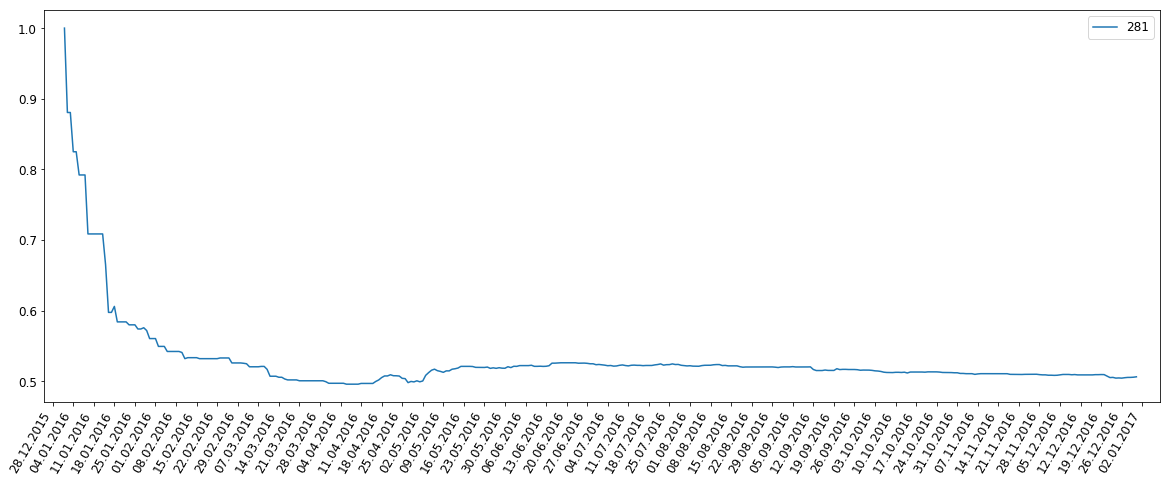

cluster: 281, 20 из 514 новостей:
	 Новый год в Париже прошел без салютов
	 Террористы ИГИЛ опубликовали видео казни пятерых «британских шпионов»
	 Британка-католичка отдала четырехлетнего сына в палачи ИГ
	 «Аль-Каида» пригрозила терактами в Риме, Мадриде и Неаполе
	 Боевик «ИГИЛ» казнил в Сирии собственную мать
	 Укрыться в Турции: к взрывам в Стамбуле причастны сторонники ИГИЛ из России
	 Профессор Грег Фили: в Индонезии активно работают вербовщики ИГИЛ
	 ИГИЛ угрожает полностью уничтожить христианство на Ближнем Востоке
	 Сулейманов заявил, что всегда был противником ИГИЛ
	 Бойня в Дэйр-эз-Зоре: игиловцы захватили более 400 человек
	 Открытые и уязвимые: как Европа может бороться с терроризмом джихада
	 С кем воюет Россия в Сирии: от генералов Саддама до боксера из Ноябрьска
	 Джимми Картер: вырезать раковую опухоль ИГИЛ будут "Кричащие орлы"
	 Европол: ИГ планирует крупномасштабные теракты в Европе
	 Бельгийские власти арестовали предполагаемого сторонника ИГ из Ирака
	 Австралийс

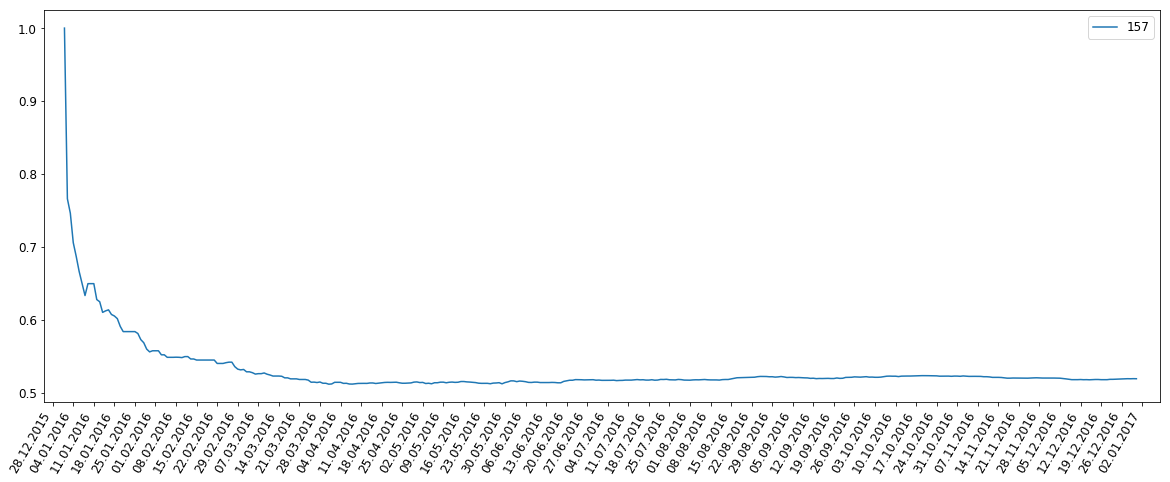

cluster: 157, 20 из 950 новостей:
	 В Красноярском крае родители погибших из-за новогодней гирлянды девочек выпрыгнули из окна, спасаясь от огня
	 Китайцам разрешили рожать двоих
	 В США ребенок погиб под весом своего отца-геймера
	 Семья, в которой погибли четверо детей, находилась под надзором органов опеки
	 Рождественские чудеса от неонатологов: в России выхаживают 70% детей с экстремально низким весом
	 Охота на детей: российские дипломаты спасли ребят, проданных цыганам на органы
	 В Таиланде обезьяна, не оценив угощения, сильно укусила малыша из России
	 Новости про материнский капитал: сколько, когда и на что
	 Пьяная мать задушила младенца подушкой, потому что "он мешал отдыхать"
	 Российские дипломаты совместно с киргизской милицией провели операцию по спасению детей-сирот
	 Звезда «Битвы экстрасенсов» Елена Люлякова: Собчак родит от другого, Безруков женится, Цыганов - нет
	 Патриарх Кирилл на Рождество привез гостинцы воспитанникам детдома для инвалидов
	 У многодетной росс

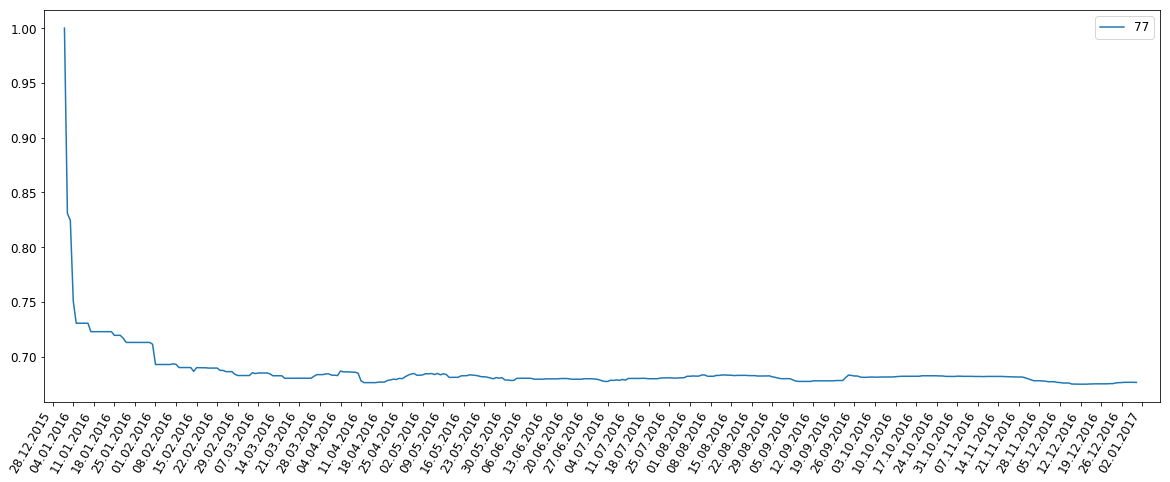

cluster: 77, 20 из 550 новостей:
	 50 петербуржцев эвакуировали из-за петарды
	 Жертвами "праздничных" пожаров в России стали четверо детей
	 Неуместное селфи: пара сфотографировалась на фоне горящего небоскреба в Дубае
	 Пожар в Дубае: подробности
	 Пожар в Ярославской области: пять погибших, четверо из них - дети
	 Пожар под Ярославлем: неизвестна судьба еще одного мужчины
	 В Ярославской области при пожаре в многоквартирном доме погибли четверо детей
	 В Ярославской области полностью сгорел многоквартирный дом
	 Число погибших в пожаре под Ярославлем возросло до шести
	 На месте пожара в Ярославской области найден шестой погибший
	 Не успели: столетний дом, в котором сгорели шесть человек, хотели расселить
	 Мать четверых погибших детей спаслась от огня в магазине
	 Спасатели разобрали завалы на месте пожара под Ярославлем
	 Ярославские погорельцы получат новое жилье в начале 2016 года
	 Трагедия под Ярославлем: дом вспыхнул как порох, жители спасались в чем были
	 Пожар в Ярославск

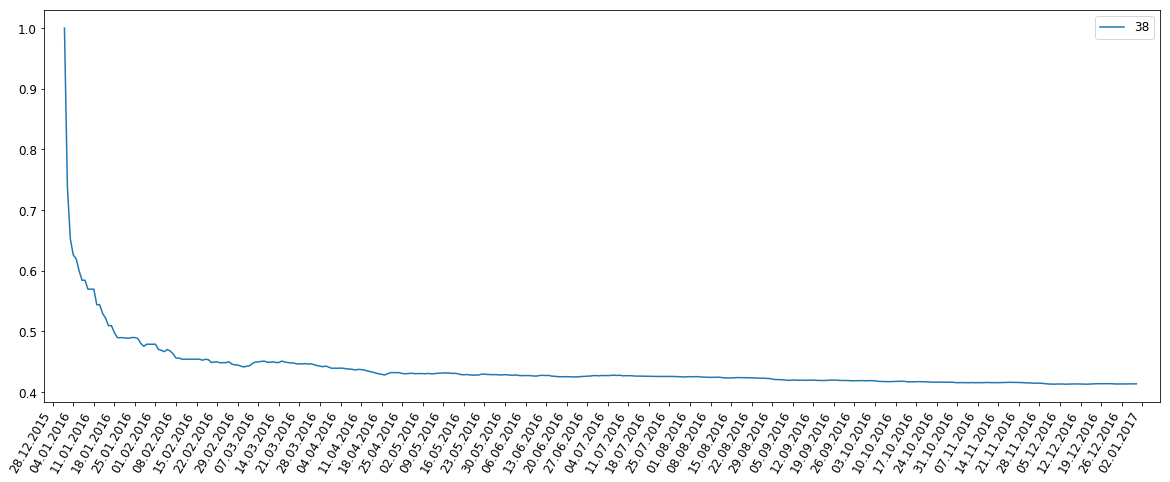

cluster: 38, 20 из 1368 новостей:
	 Путин подписал указ, контролирующий транзит грузов с Украины через РФ
	 Для транзитных грузов с Украины в Казахстан определены 5 контрольных пунктов
	 Украина откатилась в начало 90-х
	 Аксенов: дикий культ палачей и предателей - историческая вина киевской власти
	 Украина считает убытки от антироссийских санкций
	 Украина не собирается создавать в стране военную базу США
	 Яценюк: Украина выполнила все условия ЕС и ждет внедрения безвизового режима
	 Украинские FM-станции, не транслирующие украинские песни, прекратят вещание
	 "КиберБеркут": в украинском полку "Азов" служат боевики ИГ
	 В Киеве предложили закрывать радиостанции за отсутствие украинских песен
	 Кабмин Украины запретил прокат советских фильмов. Министр культуры не согласен
	 Google Translate перевел «Российскую Федерацию» как «Мордор»
	 Украина посчитала грабежом перемещение установок "Черноморнефтегаза" в РФ
	 Киевский суд арестовал буровые установки «Черноморнефтегаза»
	 В 2016 году

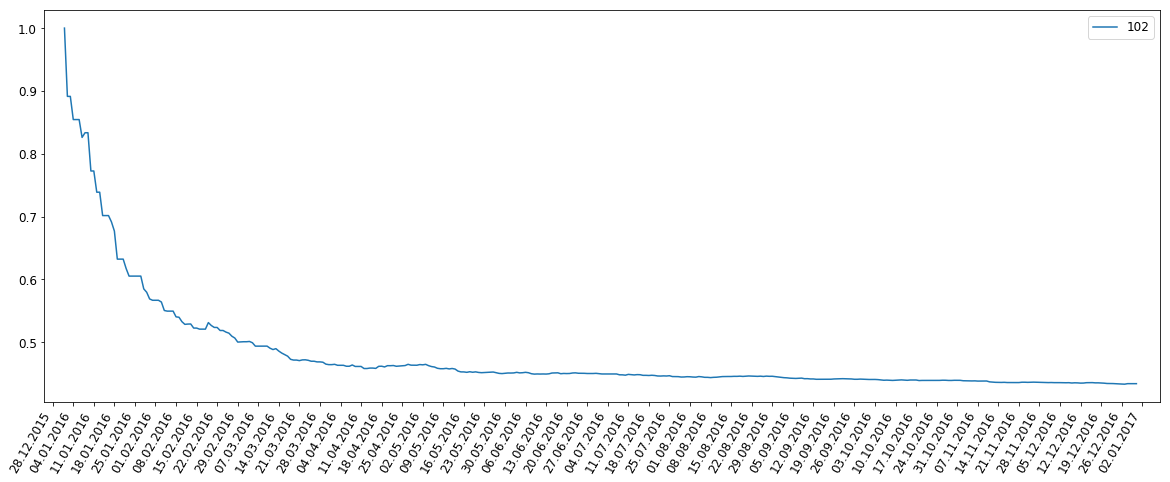

cluster: 102, 20 из 1222 новостей:
	 Бомба на Павелецком: тревога оказалась ложной
	 Москвич умер, выпив восемь бутылок паленой водки
	 В США вооруженный мужчина захватил 2-летнего сына в заложники
	 Павелецкий вокзал эвакуировали из-за звонка о бомбе
	 Самое главное за ночь: Отель в Хургаде атаковали террористы, а наши волейболистки вышли в финал отбора на Олимпиаду
	 Из вора извлекли цепочку с помощью 48 бананов
	 Жителя Коломны задержали за съемку елки и отсутствие справки о патриотизме
	 Мужчина выкинул из окна квартиры 700 тысяч рублей
	 Полиция Москвы: курсанта-практиканта не насиловали проститутки
	 Восемь человек госпитализировали из здания конгресса США
	 В центре Нью-Йорка появилась кабинка для мастурбации
	 Аргентинский турист забыл жену на бензоколонке
	 Пьяный ростовский стрелок протащил полицейского на машине и застрял в сугробе
	 И тебя вылечат: Минздрав просит не паниковать из-за психа со шприцем в метро
	 В Петербурге похитителя шашлыка опознали по куску мяса в зубах
	

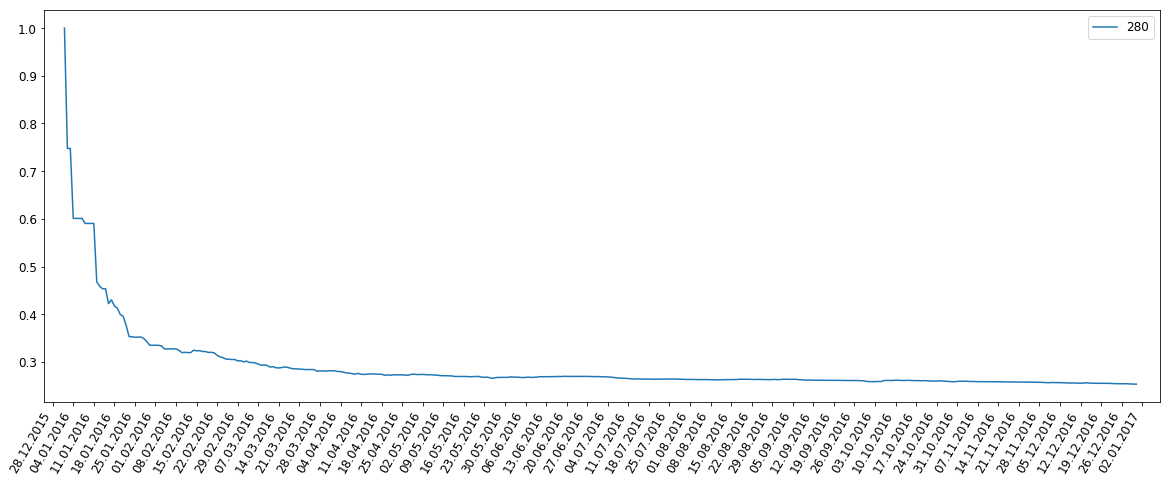

cluster: 280, 20 из 1142 новостей:
	 Почему «Стратегию 2020» заменили «Стратегией»
	 Неоптимистичный прогноз
	 Теракты в Европе: пророчество Каддафи сбылось
	 Российскую делегацию на форуме в Давосе возглавит полпред президента
	 Самое главное за праздники: десятки машин попали в снежный плен на трассе, а мигранты устроили секс-охоту в Кельне
	 Не только Украина
	 Традиционные ценности отнесли к национальным интересам России
	 Американские планы на будущее
	 Кандидат на пост главы ФИФА готов отнять ЧМ -2018 у России
	 Кровавая деконструкция
	 Греф причислил Россию к «странам-дауншифтерам»
	 «Россию нужно принимать всерьез»
	 Министру Ткачеву не дали немецкую визу
	 В Госдуме призвали Грефа уволиться после слов о «стране-дауншифтере»
	 Американская разведка займется поиском российских агентов влияния в ЕС
	 Спецслужбам США поручили выявить агентов Кремля в европейской политике
	 Визит эмира Катара в Москву: первые итоги
	 В Общественной палате призвали запретить переписку в соцсетях на 

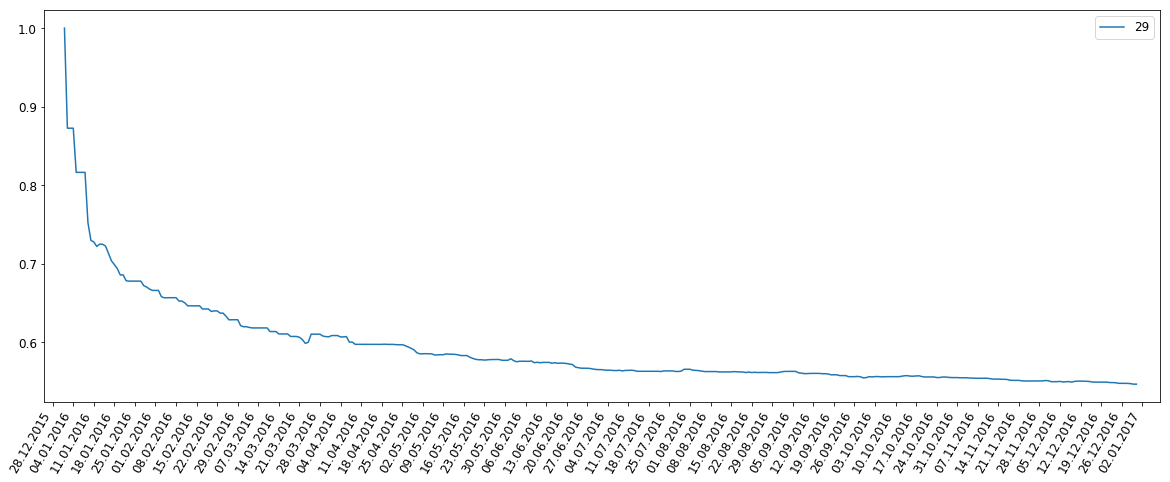

cluster: 29, 20 из 589 новостей:
	 Отдых и веселье: травматологи в Новый год работают в усиленном режиме
	 Рак заморозили и убили
	 «Приехали на вызов к переевшему человеку, а спасать пришлось Деда Мороза со Снегурочкой»
	 В Китае бульдозер снёс больницу и часть морга вместе с трупами
	 В белгородской больнице врач одним ударом убил пациента
	 Роковой удар: врач убил пациента за оскорбление медсестры. Видео
	 Шокирующий случай произошёл в одной из больниц Белгорода
	 СМИ сообщили о попытке замять историю с убийством пациента в больнице Белгорода
	 Стало известно имя пациента, до смерти избитого в белгородской больнице
	 "Врач-боксер", убивший пациента, уволен и отпущен под подписку
	 «Смерть в белом халате»: почему врач повел себя как на боксерском ринге?
	 Убойный прием
	 Смертельный нокаут: белгородский врач вступился за медсестру
	 Спутник убитого пациента рассказал подробности инцидента в белгородской больнице
	 Во "Врачей без границ" снова прилетела ракета
	 Санкт-Петербург: больн

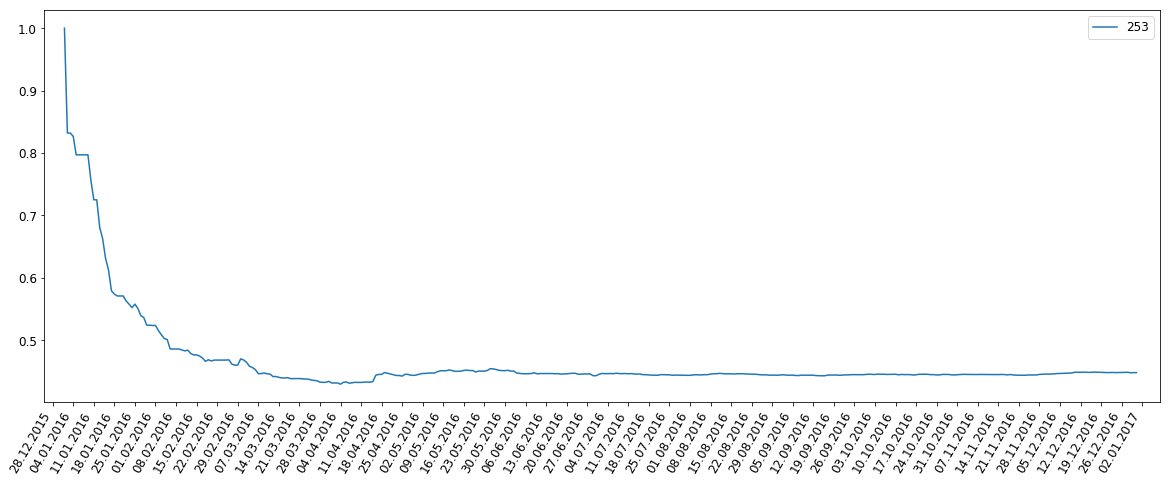

cluster: 253, 20 из 874 новостей:
	 Российских чиновников научат скромности
	 Росприроднадзор собрался отсудить у Деда Мороза 15 тысяч рублей
	 Росприроднадзор требует от Деда Мороза 15 тысяч рублей
	 В квитанциях за услуги ЖКХ появится новая строка
	 В США менее чем через сутки объявят победителя самой крупной лотереи
	 Особняк Playboy в Лос-Анджелесе выставят на продажу за $200 миллионов
	 Особняк основателя журнала Playboy продается вместе с хозяином
	 В США разыгрывают в лотерее свыше одного миллиарда долларов
	 Путешествие по Центральной Азии: Светлый путь по-узбекски
	 Dior оценил сумку уборщицы «Газпрома» в два миллиона
	 У уборщицы «Газпрома» украли сумочку за 300 тысяч рублей
	 Полиция: уборщица "Газпрома" переживала не за похищенную сумку, а за 15 тысяч рублей
	 Украденная у уборщицы «Газпрома» сумка оказалась подделкой
	 Понты дороже денег: Сеть обсуждает, как уборщица "намыла" сумку первой леди
	 Выиграй 1,5 миллиарда долларов вместе с «Комсомолкой»!
	 В Москве ускорилось п

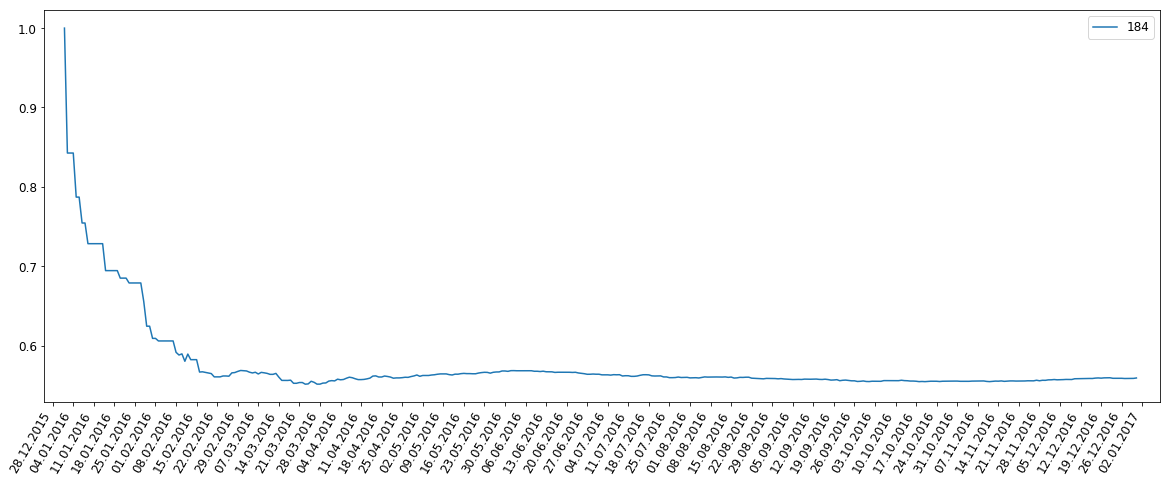

cluster: 184, 20 из 654 новостей:
	 Гороскоп от Павла Глобы на 2016 год: Стрельцам не кашлять и Львам не болеть!
	 Исследователи назвали самый легкий и приятный способ оздоровиться за время праздников
	 Холода полезны для здоровья! Пять плюсов минуса
	 Воскрешать людей из мертвых начнут в 2045 году
	 Семь болезней, которые передаются от матери
	 Через пять лет создадут идеальную диету по генам?
	 На кого станут похожи наши далекие потомки
	 Выводы ученых: Пиво отрицательно влияет на память
	 Хирурги подтвердили реальность пересадки головы программиста Спиридонова
	 Хирург Серджио Канаверо: мы доказали, что трансплантация головы возможна
	 Эксперименты подтвердили: трансплантация человеческой головы реальна
	 Оральный секс признали опасным для здоровья
	 Весь Интернет может поместиться в одной человеческой голове
	 Секс под микроскопом
	 За вождями СССР следили из унитаза
	 Назван способ похудения с набором мышечной массы
	 Почему строительство рая на Земле закончилось адом
	 Чтобы дожи

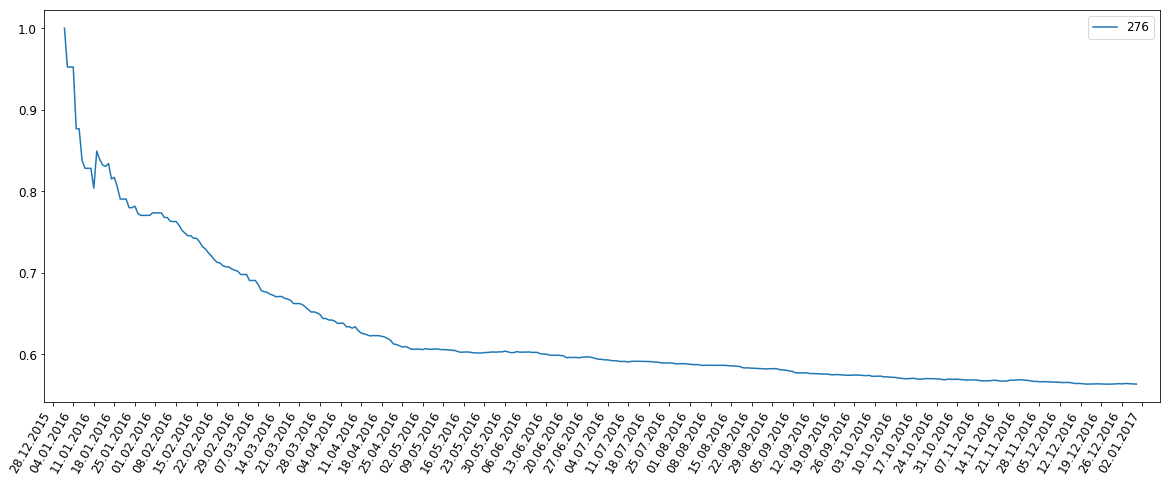

cluster: 276, 20 из 823 новостей:
	 В США умерла певица Натали Коул
	 Челябинская филармония исполнит саундтреки культовых видеоигр
	 В Сирии перед российскими военнослужащими выступила певица Юлия Чичерина
	 Юмористам из знаменитого дуэта "Кролики" пригрозили «коктейлем Молотова» за выступление на телеканале "Россия-1"
	 Рождество на Розе Хутор вместе с Григорием Лепсом
	 У фронтмена Scooter роман с 19-летней русской студенткой
	 Скончался легенда британского рока Дэвид Боуи
	 Ушел из жизни легенда британского рока Дэвид Боуи
	 Скончался известный британский певец Дэвид Боуи
	 Дэвид Боуи умер от рака
	 Скончался Дэвид Боуи
	 Умер музыкант Дэвид Боуи
	 "Смотрите, я на небесах". Последний клип Дэвида Боуи
	 Сын Дэвида Боуи показал архивное фото с отцом
	 Мадонна о Дэвиде Боуи: «Этот великий художник изменил мою жизнь»
	 Невероятный и изысканный: с Дэвидом Боуи ушла целая эпоха
	 Прах к праху
	 Закончилась эпоха Дэвида Боуи. Реплика Максима Кононенко
	 К черной звезде
	 Дэвид Боуи. Звезд

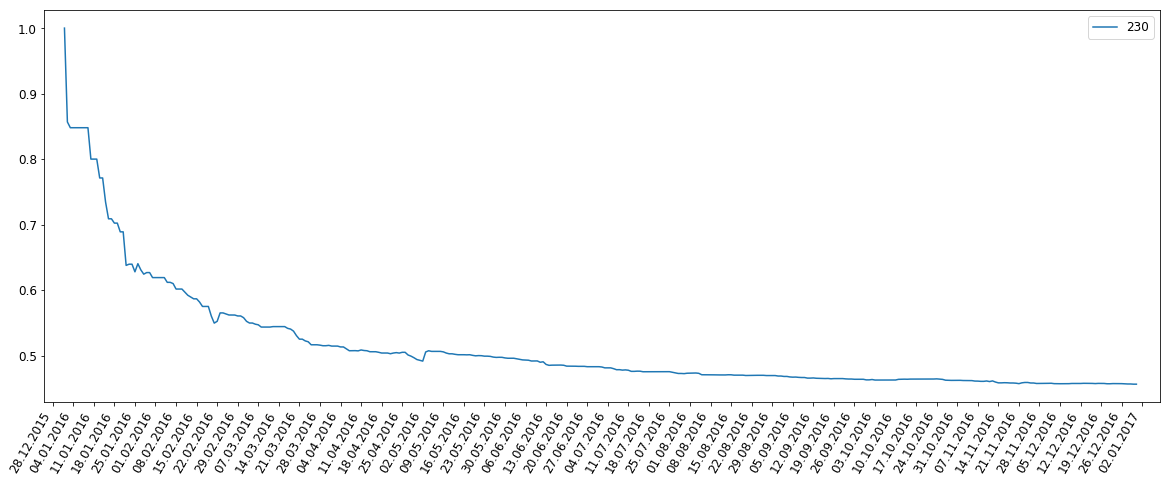

cluster: 230, 20 из 571 новостей:
	 Украинские националисты провели факельное шествие в честь Бандеры
	 Все надежды украинские националисты возложили на покойника
	 В Киеве радикалы провели факельное шествие в честь дня рождения Степана Бандеры
	 В Кёльне проходит массовая акция движения «Пегида» и других ультраправых организаций
	 Радикалы закидали парламент Косова коктейлями Молотова
	 Предводитель московских беспорточников вернется в метро без штанов
	 Митинги в Кишиневе: Европа советует Молдавии самой решать свои проблемы
	 В Сочи пенсионеры перекрыли движение на одной из центральных улиц
	 В Германии фермеры протестуют против принятия соглашения о свободной торговле между США и Евросоюзом
	 Во время акции памяти Маркелова задержали 15 православных активистов
	 Корреспонденту ВГТРК закрыли въезд в Молдавию на пять лет
	 Молдавия. Начало.
	 Обряд посвящения после полуночи: тайно, за 6 минут, в Молдавии сменилось правительство
	 Беспорядки в Кишиневе: Ренато Усатый дорвался до телеви

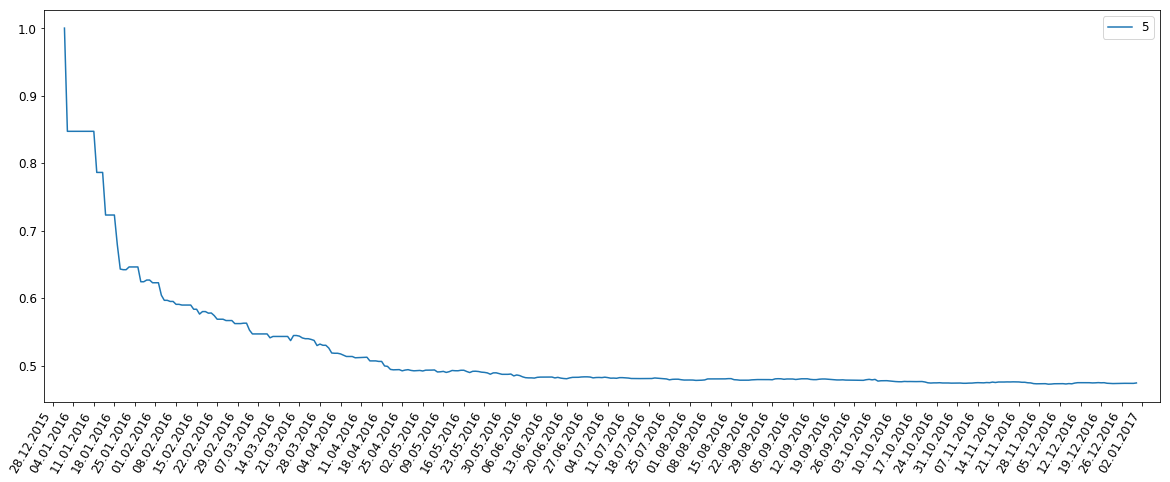

cluster: 5, 20 из 654 новостей:
	 Хулиганы сожгли в Париже 804 автомобиля за одну ночь
	 Правосеки устроили перестрелку в Карпатах из-за счета в ресторане
	 В России раскрыта крупная сеть поставки героина
	 Уволенный сотрудник застрелил директора и замдиректора столичной фирмы
	 Задержан подозреваемый в подрыве гранаты на остановке в Москве
	 Пойманный в Москве наркокурьер растрогал полицейских, попрощавшись со своим котиком
	 Ульяновские студентки, избившие сверстницу, поучаствовали в ток-шоу
	 Три девушки готовили теракт в Ростовской области
	 В Красноярске задержан менявший наркотики на фрукты сыроед
	 Квантовый секс-скачок: на Кубани арестован глава секты
	 Сигнал планшета помог найти вора, укравшего миллион
	 Пистолеты и Коран в парижском "Диснейленде": спутница задержанного все еще на свободе
	 Полиция задержала пьяного мужчину, который "заминировал" московские вокзалы
	 Явки, пароли, закладки: банды наркоторговцев с Украины задержаны в трех округах России
	 В нескольких регионах

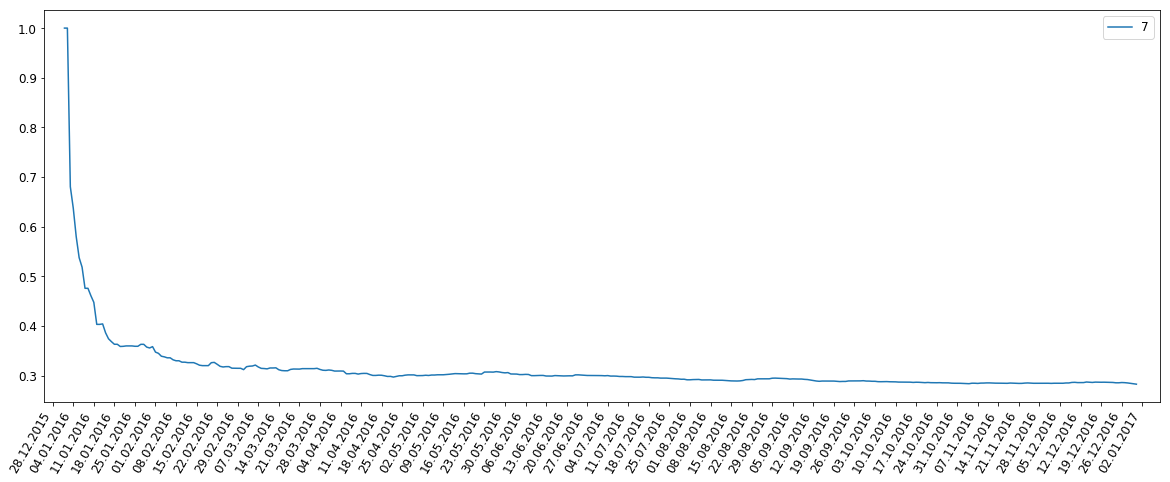

cluster: 7, 20 из 681 новостей:
	 Александр Захарченко: Перед Новым годом у нас родились тройняшки. Их назвали... ДНР
	 «Если надо, то мы пальцем будем подтираться»
	 Александр Ежевский: Сталин мне сказал: срочно отгрузите трактора Казахстану! А Брежнев назначил... тамадой
	 Второе пришествие Мао
	 Скромное обаяние комсомола
	 «Свет в тоннеле не видит никто»
	 Дружба народов и некрасивый бюст Сталина
	 «Ваша честь, в лесу ему было бы страшнее, чем в багажнике»
	 «Возрождение России совершится на религиозной почве»
	 Отцы и дети
	 «У немецкого антисемитизма глубокие корни»
	 Президент России Владимир Путин дал интервью немецкому изданию Bild
	 Владимир Путин: Я не друг, не невеста и не жених, я президент Российской Федерации. Я отстаиваю интересы 146 млн человек
	 Путешествие по Центральной Азии: Хороший муж, хороший дом – что еще нужно, чтобы встретить старость?
	 Дионисий Поздняев: на службы мы летаем на самолетах
	 Европа меняет кожу. Реплика Александра Проханова
	 Право на надежду: 

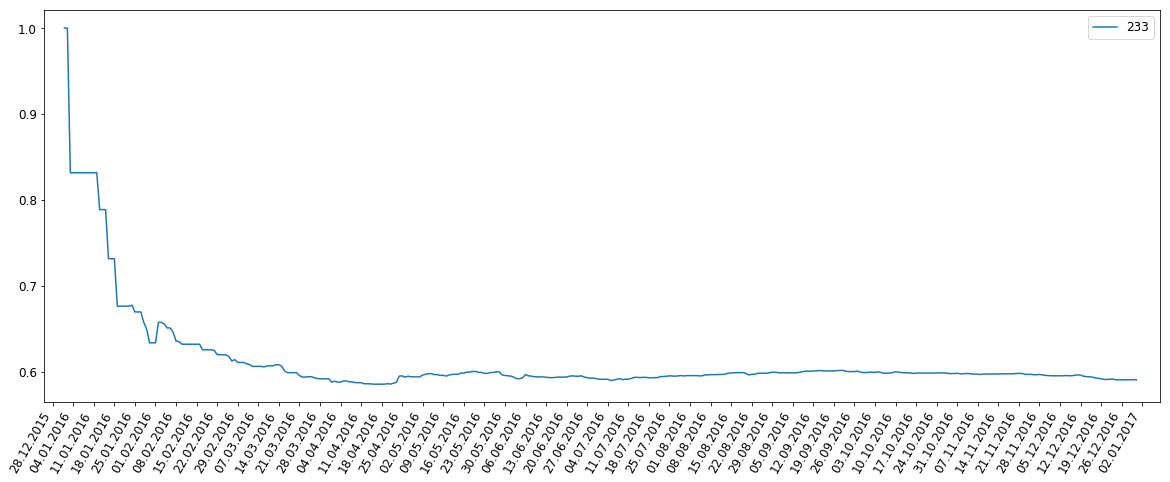

cluster: 233, 20 из 616 новостей:
	 C 1 января штрафы можно оплачивать наполовину!
	 Психически здоровый исламист давил французских солдат без умысла на теракт
	 Дышать в алкотестер гаишника вы не обязаны
	 Должников по штрафам и алиментам высадят из-за руля
	 Что делать, если коммунальщики повредили ваше авто
	 Житель Омска разбился во время катания на прикрепленных к автомобилю санках
	 В Петербурге машина украинского консульства насмерть сбила пешехода
	 Машина Генконсульства Украины в Петербурге сбила на тротуаре пенсионерку
	 Лишенная прав автоледи прокатила гаишника на капоте своей "Хонды"
	 Таксист, скинувший гаишника с эстакады ТТК, ездил с просроченными правами
	 Перебравших пассажиров Uber решили развлечь детскими игрушками
	 Движение по Военно-Грузинской дороге блокировано уже пятые сутки
	 Смертельно пьяный водитель смог назвать полиции только имя президента. Видео
	 Автомобильное братство во Владимире помогает тем, кто оказался в трудной ситуации на дороге
	 Водители побил

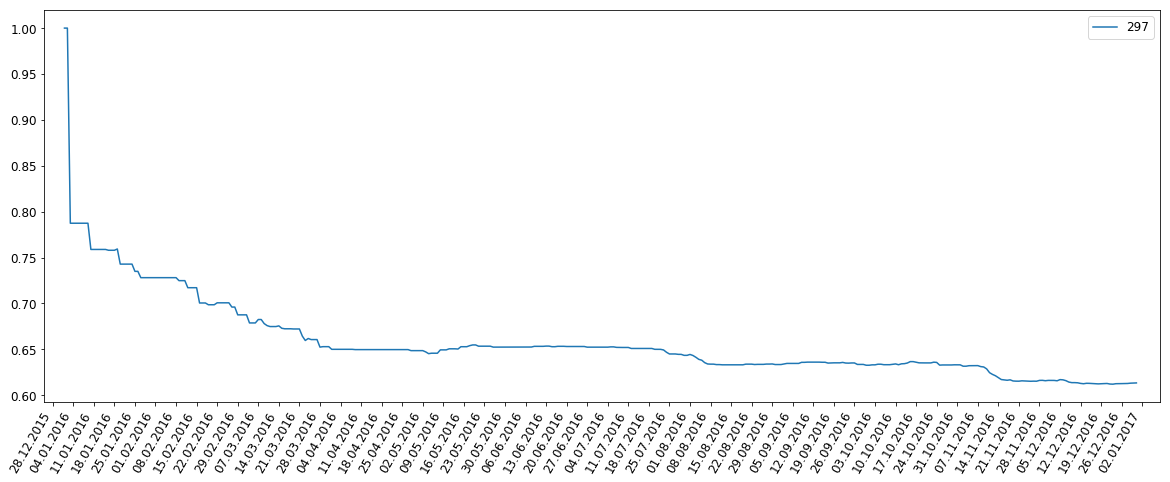

cluster: 297, 20 из 675 новостей:
	 Небо над Калифорнией разукрасили оскорбительными фразами в адрес Трампа
	 В Калифорнии в небе над Парадом роз появились оскорбительные фразы про Трампа
	 Женщину-мусульманку выгнали с предвыборного митинга Дональда Трампа
	 Дональд Трамп сорвался на микрофон
	 Трамп заявил о своих «хороших отношениях с Богом»
	 В британском парламенте с жаром обсудили поведение Дональда Трампа
	 Трамп похвастался возможностью стрелять в людей без потери голосов избирателей
	 Трамп сравнил ситуацию в экономике США с пузырем
	 Трамп решил стать президентом после неудачной попытки купить футбольный клуб
	 Трамп подсчитал стоимость строительства стены на границе с Мексикой
	 Неожиданный друг: как Владимир Путин получил поддержку в США
	 Дональд Трамп вступил в публичный спор с папой римским о религии
	 Трамп пообещал, что скоро будет вести себя, как "настоящий президент"
	 Бывший лидер Ку-Клукс-Клана поддержал Трампа
	 Трамп сравнил границы США со швейцарским сыром
	 Ген

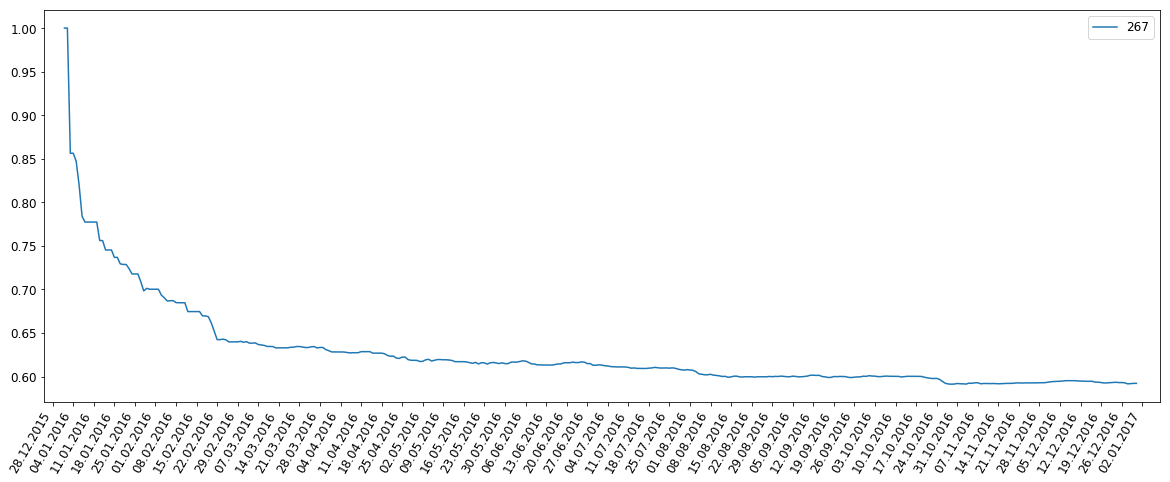

cluster: 267, 20 из 712 новостей:
	 Разгадать тайну эвенкийских оленей помогли высокие технологии
	 В Центре разведения леопардов в Сочи готовятся выпустить в дикую природу двух редких хищников
	 Еще одного истощенного тигренка-сироту спасли в Приморье
	 В Европе переписали чуждую флору и фауну
	 Спасение тигрят: несколько маленьких хищников вышли к людям в Приморье
	 Один из найденных в Приморье тигрят умер
	 Кот-мэр всем пример
	 Спасенный в Калифорнии фиолетовый котенок подружился со слепой кошкой
	 Великобритания разрешит выращивание химер из свиней и овец с органами человека
	 В Хабаровске дикий кабан решил прогуляться по одному из спальных районов города
	 В заповеднике «Бастак» «фотоловушки» засняли редкие кадры — трехмесячных детенышей тигрицы Золушки
	 Детям Приморского края запретят выгуливать собак
	 Толстый кот покачал пресс на камеру
	 Криобиологи оживили находившихся в 30-летней заморозке тихоходок
	 Кот, похожий на злодея из "Звездных войн", стал звездой в Сети и нашел х

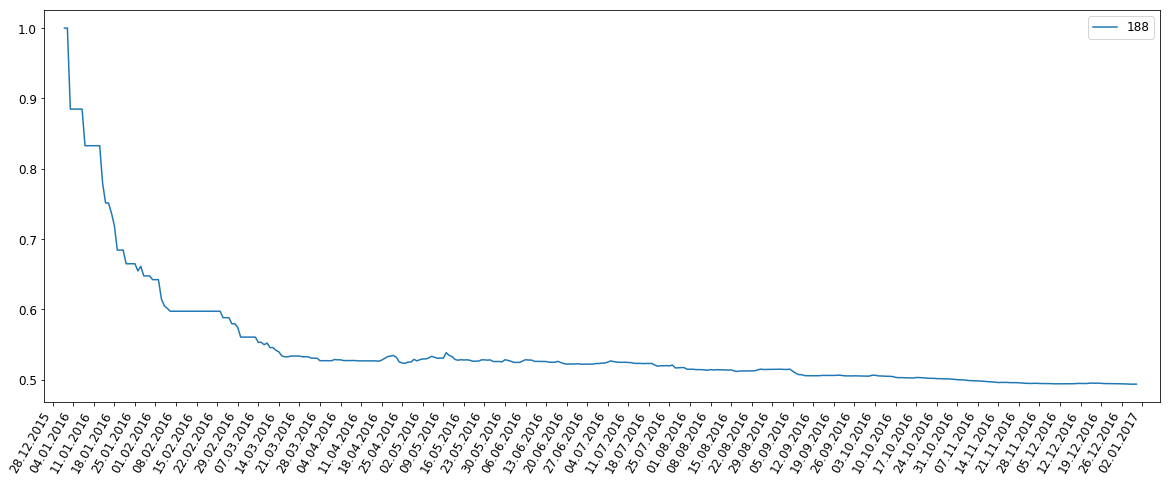

cluster: 188, 20 из 708 новостей:
	 Драка в Челябинской области закончилась массовым убийством
	 Проверявший бронежилет израильский тележурналист получил ножевое ранение
	 В Твери на морозе у больницы умер пациент, не дождавшийся помощи медиков
	 Французские спасатели вторые сутки прочесывают Альпы в поисках людей, попавших под сход лавины
	 Мужчина устроил сожжение бывшей жены в Южном Бутове
	 Мужчину в Нью-Йорке избили под крики "ИГИЛ"
	 На юго-западе Москвы застрелили двух человек
	 В Москве 11-летний школьник случайно застрелился из травматического пистолета
	 В Москве жестоко избили известную журналистку
	 Охранник от скуки решил сыграть в русскую рулетку и прострелил себе голову
	 Москва: сын расстрелял родителей из карабина и покончил с собой
	 Петербуржец открыл стрельбу в магазине «Пятерочка» из-за палки колбасы
	 На трассе «Скандинавия» в Выборгском районе в серьёзную аварию попал туристический автобус
	 Журналист побил хулигана, пристававшего к нему с надувным бананом. Видео

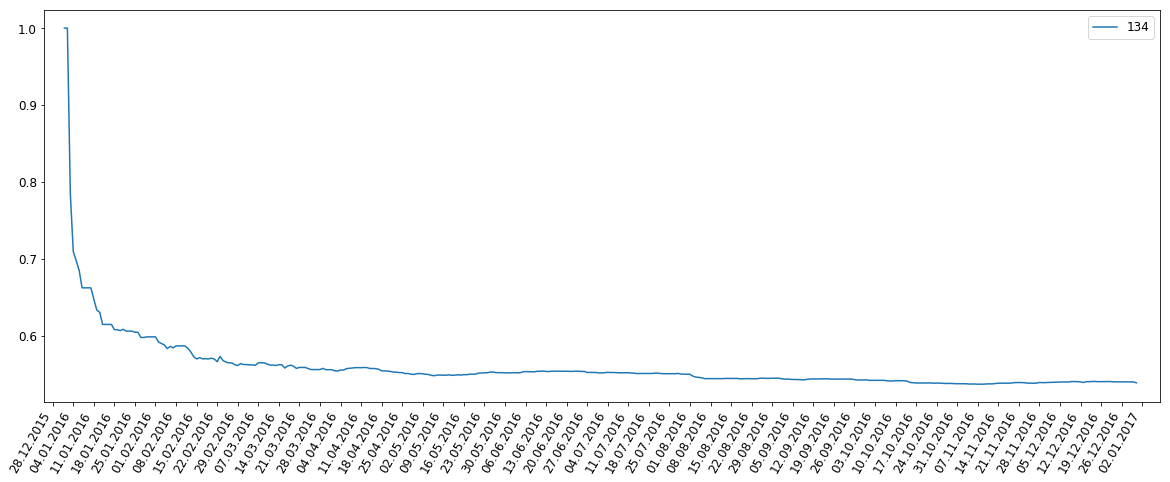

cluster: 134, 20 из 491 новостей:
	 Нападение на базу ВВС Индии: ликвидированы четыре боевика, трех ищут
	 На севере Синая уничтожены 60 боевиков
	 Правительственные войска Сирии вернули под свой контроль пригород Дамаска
	 Ради ликвидации террориста индусы взорвали часть собственной авиабазы
	 ИГ выложило видео убийства пятерых "британских шпионов"
	 Вооруженные боевики напали на индийское консульство в Афганистане
	 Армия Асада успешно наступает в ключевых районах Сирии
	 ИГИЛ атаковала один из крупнейших нефтяных портов Ливии
	 ИГ заявляет о захвате ливийского города близ важного нефтяного порта
	 Курды теснят ИГИЛ на севере Сирии
	 МИД РФ: боевики ИГИЛ могут использовать химоружие
	 В Сирии ликвидированы несколько полевых командиров ИГ
	 СМИ узнали о работах ИГ по созданию ракет класса «земля-воздух»
	 "Военный министр" ИГ уничтожен ударом ВВС Ирака
	 Антитеррористическая коалиция подвела итоги декабря: уничтожены 2,5 тысячи боевиков ИГ
	 Пассажирка помогла полиции задержать израил

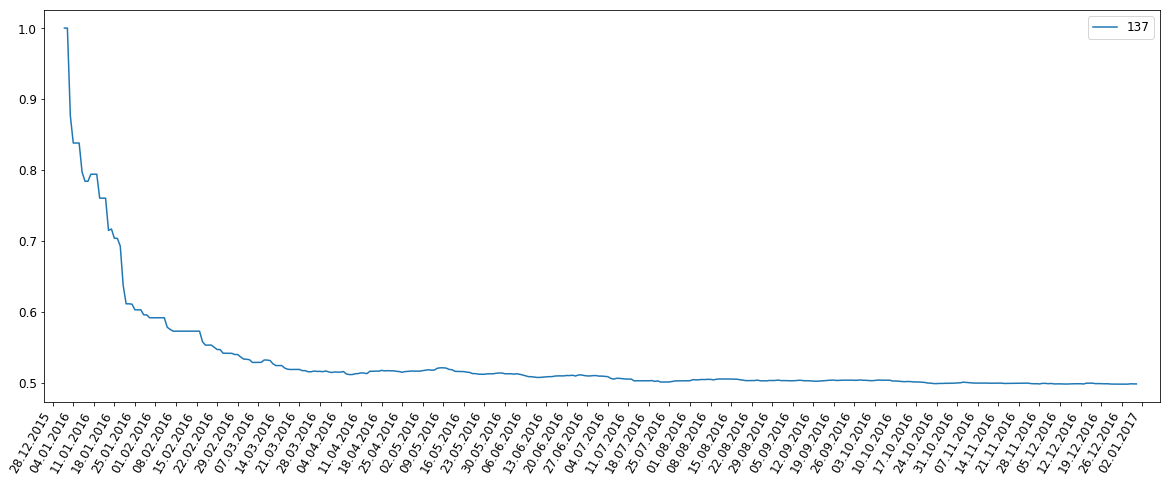

cluster: 137, 20 из 705 новостей:
	 В Нью-Йорке обидчиков трансгендеров будут штрафовать на 250 тысяч долларов
	 Крис Браун избил фанатку за фотографию
	 Испанская фирма предложила беременным вагинальный динамик для будущих меломанов
	 Приложение для Gmail отучит женщин извиняться
	 Приложение для браузера Chrome отучит женщин извиняться
	 ООН: миротворцы-педофилы платили за секс
	 Захарова допустила назначение женщины главой российского МИД
	 В московском фитнес-клубе двух женщин ударило током на беговых дорожках
	 Рабыни тщеславия
	 Изуродованная кислотной атакой женщина стала лицом бренда одежды
	 Застрявшую в поясе верности итальянку пришлось спасать пожарным
	 В США обманутый муж заставил жену пройтись по улице голой
	 Бездомная румынка родила на площади Святого Петра в Ватикане
	 В Швеции начинается судебный процесс над врачом, которого обвиняют в похищении возлюбленной
	 Число ВИЧ-инфицированных в России достигло 1 млн человек
	 Облитая кислотой жительница Индии стала лицом модн

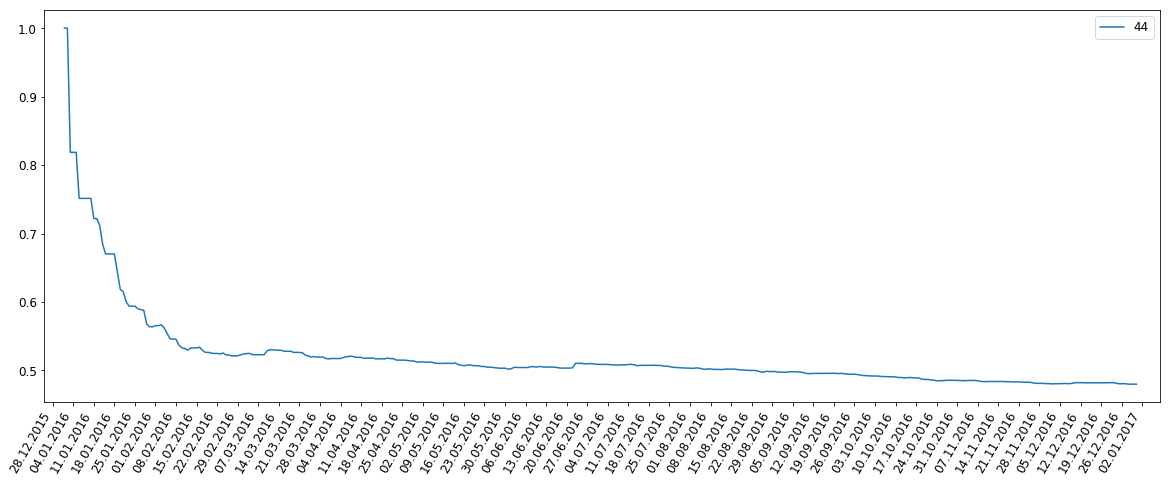

cluster: 44, 20 из 688 новостей:
	 Украина ввела запрет на поставки продуктов из России
	 Украина год не сможет свободно торговать с Россией
	 Ценники в магазинах сделают понятнее
	 Магазинам разрешили оформлять ценники по новым правилам
	 Брянская область - территория возможностей
	 Медведев расширил перечень жизненно необходимых лекарств
	 20 января Иран начнет поставки молочных продуктов в Россию
	 Украина запретила ввоз российских товаров
	 Россельхознадзор требует остановить мясное производство в пяти "Ашанах"
	 Антисанкционная корзина: чем ретейлеры заменили турецкие продукты
	 Продажи компьютеров упали до исторического минимума
	 Игрушечные деньги: как заработать на франшизе магазина детских товаров
	 Питерские предприниматели наладили продажу "духовных скреп"
	 В Россию не пустят бразильскую говядину
	 Российские ретейлеры предложили вскрывать посылки из-за рубежа
	 Ретейлеры предложили вскрывать иностранные посылки для борьбы с контрафактом
	 Ритейлеры попросили таможню вскрыв

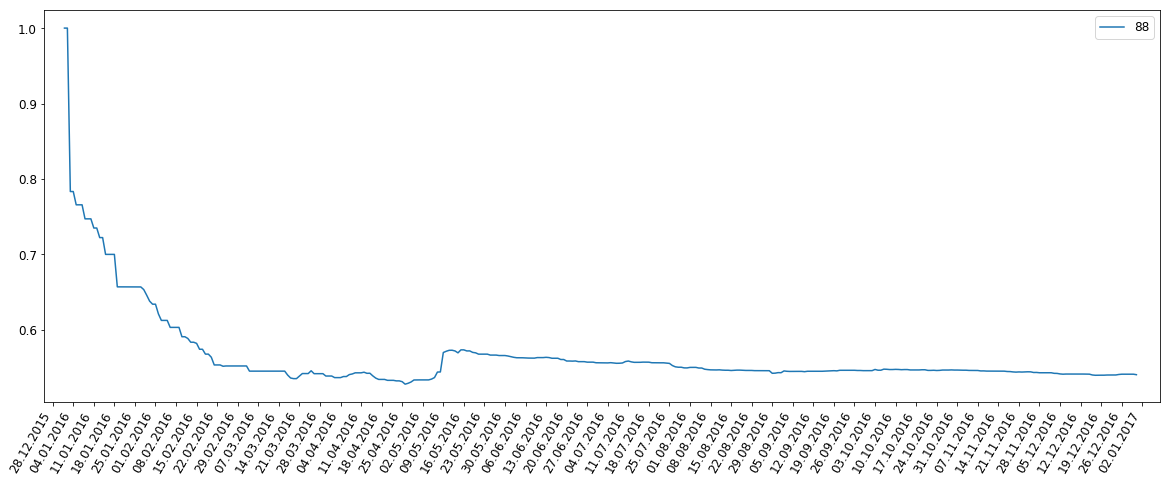

cluster: 88, 20 из 548 новостей:
	 Суровые челябинские разборки: четыре человека застрелены в новогоднюю ночь
	 Массовое убийство под Челябинском могло быть самообороной
	 «Челябинский стрелок» убил четверых, защищая жену и маленькую дочь
	 Мужчину задушили проволокой у Бутырки
	 Возможный убийца четырех человек вышел из СИЗО после просьбы главы СКР
	 Жителя Владивостока задержали по подозрению в убийстве четырех человек
	 Психиатры обследуют мужчину, растерзавшего свою семью на Рождество
	 Сын миллиардера Сосина час душил и кусал мать, пока та не перестала дышать
	 Уволенный за кражу денег москвич расстрелял своего бывшего начальника и его зама
	 В Москве задержан предполагаемый убийца двух топ-менеджеров
	 В Москве уволенный сотрудник расстрелял бывших работодателей в офисе компании
	 Версия: Мужчина расстрелял своих бывших начальников из-за долгов по зарплате
	 Двойное убийство в Москве: судьба подозреваемого решится завтра
	 20-летний юбилей сын олигарха Сосина отметил в тюремной б

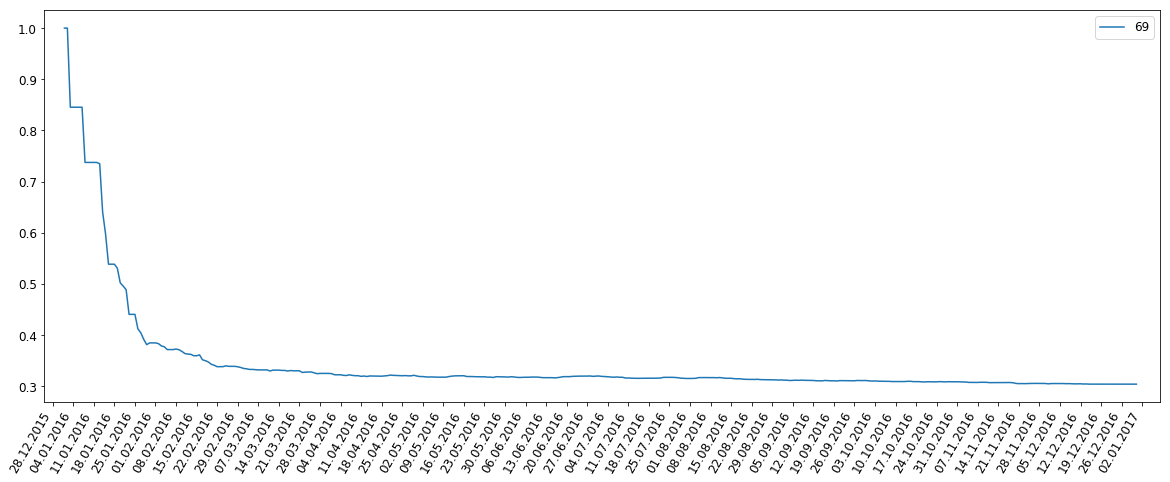

cluster: 69, 20 из 759 новостей:
	 В России утверждена программа патриотического воспитания
	 Уход банкиров: почему топ-менеджеры крупных банков покидают профессию
	 Деньги на крови: стоит ли открывать по франшизе пункт приема анализов
	 Сергей Курков Скважина инноваций: что мешает снизить себестоимость нефти
	 Чек по интернету
	 Презумпция виновности: как психология россиян мешает экономическому росту
	 Неустранимое меньшинство
	 Президент «Евросети» — РБК: «Наш бизнес — столик на 100 ногах»
	 Это не кризис. Это другая реальность
	 Инвесторы потеряли интерес к строительству новой трассы вокруг Москвы
	 Как мы открывали собственную кофейню. Часть 5
	 Без мировых аналогов: армии России предложили оружие будущего, "Аватаров" и боевых роботов
	 Байден в Давосе предупредил человечество об угрозе потерять душу
	 Счетная палата: Госденьги тратили на разведение австралийских раков
	 В городе-офисе жизни нет
	 Запрос на утопию
	 Гараж для стартапера: как мастерские TechShop вернули моду на «же

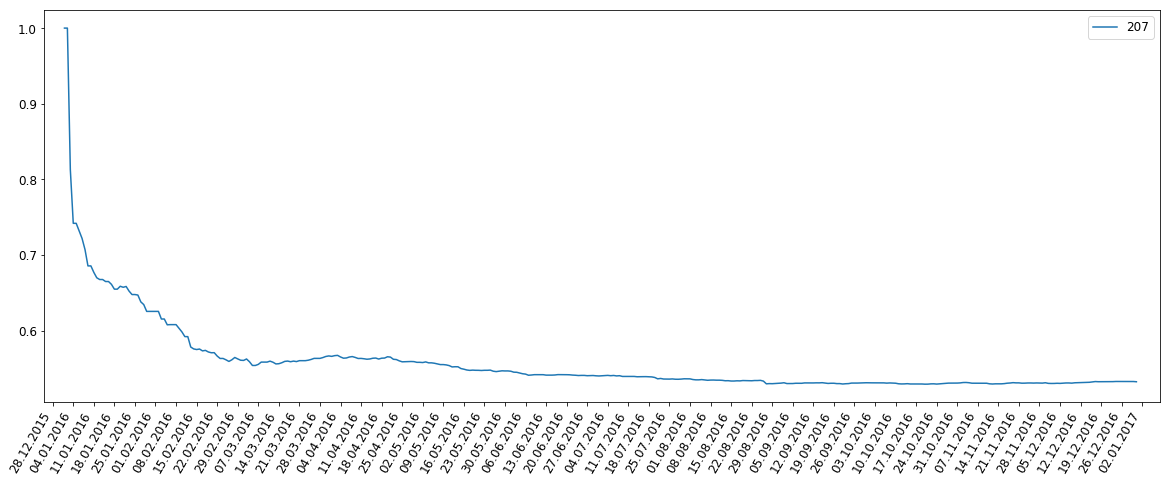

cluster: 207, 20 из 849 новостей:
	 Веселая наука
	 Перестроить историю
	 Таблица Менделеева пополнилась четырьмя новыми элементами
	 Контрабанде бивней мамонта из России поставлен заслон
	 В Подмосковье нашли богатый клад с вооружением времен Ивана Грозного
	 В периодическую таблицу Менделеева добавили четыре новых элемента
	 В Испании под арабской крепостью нашли древнеримский город
	 Земля упырей
	 Археологи обнаружили место крупнейшей катастрофы в истории китобойного флота
	 Мамонты и динозавры готовы вернуться
	 Ледяной человек Эци мог страдать от язвы желудка
	 Математики изобрели новые способы нарезки пиццы
	 Химия, глисты и смерть
	 Американцы утроили КПД лампочки Ильича
	 Люди остановили наступление ледниковой эпохи
	 Сенсационное открытие петербургских археологов: Арктический человек убил мамонта Женю 45 тысяч лет назад
	 Калининградский ученый успокоил американцев: Извержение «супервулкана» в ближайшее время не предвидится
	 Показано видео выброса пепла вулканом Жупановский 

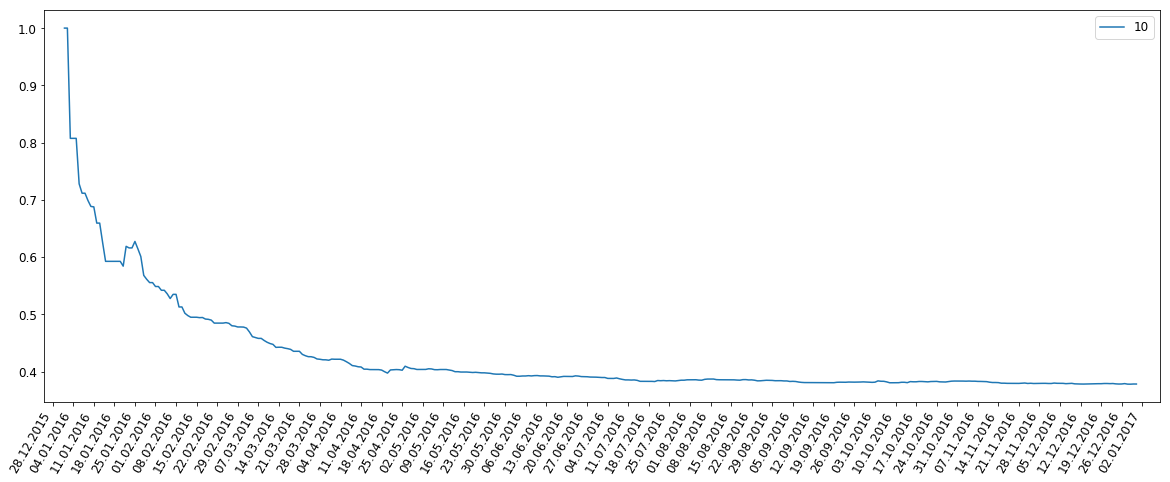

cluster: 10, 20 из 1024 новостей:
	 Британских военных подозревают в убийствах и пытках мирных иракцев
	 Из базы Интерпола пропали данные правосека Дмитрия Яроша
	 Бывший главарь «Правого сектора» Ярош пропал из базы розыска Интерпола
	 ЕСПЧ обязал Россию выплатить €25 тыс. фигуранту «болотного дела»
	 Россиянин может попасть в финскую тюрьму за ввоз беженцев
	 Страсбургский суд обязал Россию выплатить 32 тысячи евро фигуранту Болотного дела
	 "Оружейник" террориста из Сан-Бернардино не признал вину
	 Москва призывает Хельсинки одуматься и не выдавать россиян Сенаха и Сергеева США
	 Бежавший через канализацию наркобарон Коротышка мечтал снять о себе кино
	 На след наркобарона Коротышки мексиканские власти вывел актер Шон Пенн
	 Чайка: информационные атаки на Генпрокуратуру не ослабят ее хватку
	 Сына бизнесмена Шарыго арестовали за насилие над моделью
	 Мексиканский наркобарон просил Шона Пенна снять о нем кино, а попал в тюрьму
	 С Виктора Бута сняли тюремные ограничения
	 ЕСПЧ разреш

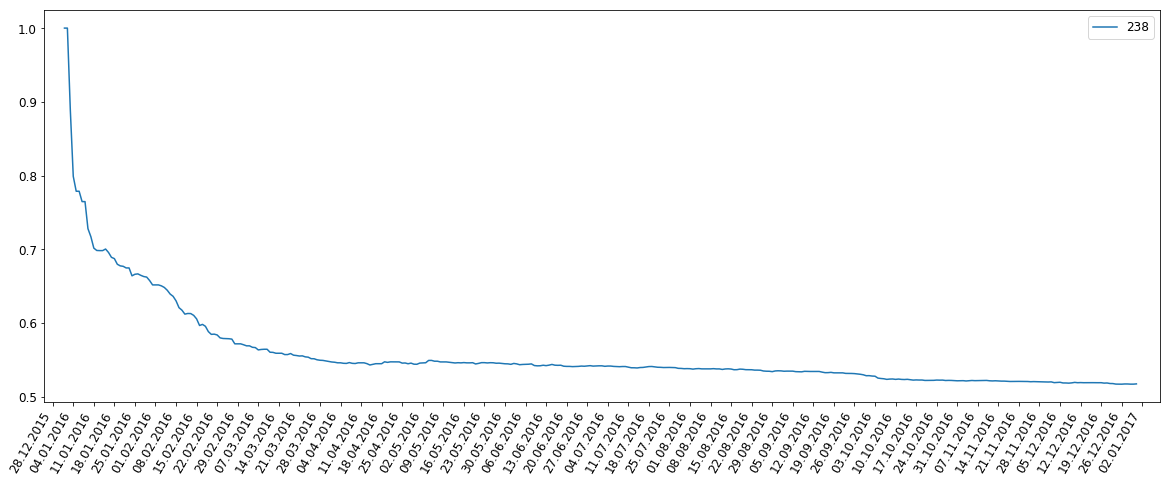

cluster: 238, 20 из 966 новостей:
	 Свадебный наряд Нетребко мастерицы вышивали восемь месяцев
	 Поклонников Ольги Бузовой удивило полное отсутствие у нее груди
	 70 лет назад появился раздельный купальник — бикини, который открыл новую эпоху в мире красоты
	 Алла Пугачева впервые показала видео подросшей дочки
	 20 лучших звездных декольте
	 У сестры Майкла Джексона Дженет Джексон подозревают рак гортани
	 Пугачева сняла на видео своего 2-летнего сына
	 Брежнева рассказала всю правду о “тайной свадьбе” Меладзе и Джанабаевой
	 Ирина Шейк отметила 30-летие в бикини
	 Двум россиянкам запретили приближаться к американской певице Лане Дель Рей
	 Кэти Топурия и Ирина Аллегрова порадовали поклонников смелыми нарядами на концерте в «Розе холл»
	 На «Миссис бабушка Вселенная» поедет 38-летняя певица из Петербурга
	 Рождество на Роза Хутор: Цены, звезды и любовь
	 Пугачева провела праздники с детьми и без мужа, а Собчак соревновалась с Волочковой
	 Лучшие наряды «Золотого глобуса»: Дженнифер Ло

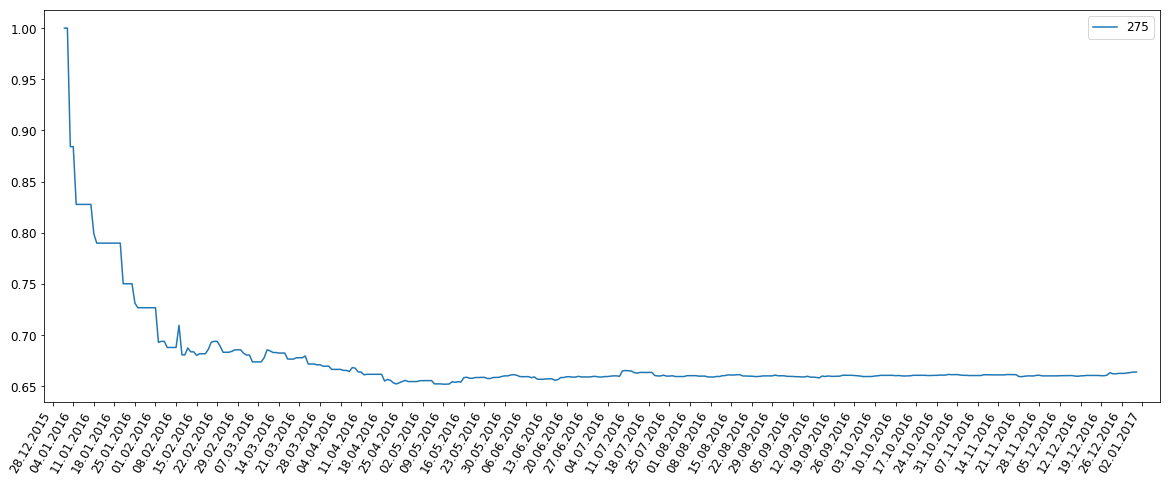

cluster: 275, 20 из 518 новостей:
	 В Лондоне из-за сбоя системы общественный транспорт стал бесплатным
	 В Приамурье полиция и прокуратура выясняют причины катастрофы на железной дороге
	 На Украине замерз поезд из Львова в Киев
	 Москвичи впервые прокатились "В метро без штанов"
	 Полиция ищет всех, кто ездил в метро без штанов
	 Участниками акции «В метро без штанов» заинтересовалась полиция Москвы
	 Участники флешмоба «В метро без штанов» причислили себя к моржам
	 В Новой Москве вооруженные битами подростки напали на пассажиров электрички
	 Полиция рассказала о нападении в московской электричке
	 Нетрезвый пассажир метро из любопытства провалился в эскалатор
	 В московском метро запустили молнии
	 В России нашелся инвестор для реализации проекта сверхзвукового поезда
	 Станцию столичного метро на одну ночь превратили в научную лабораторию
	 В Лондонском метро появился "русский богатырь"
	 В Казахстане потерялся отправленный в обход России украинский поезд
	 Потерявшийся украинский

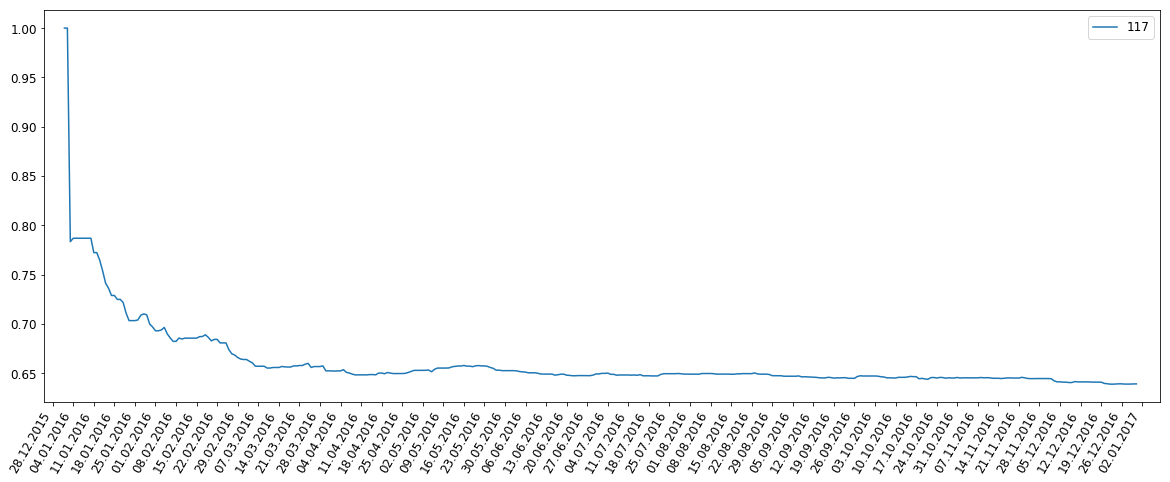

cluster: 117, 20 из 511 новостей:
	 Уход в трехлитровые банки
	 В новогоднюю ночь из столичного банка вынесли 12 миллионов
	 Герман Греф раскритиковал Европейский центробанк
	 Сына Патрушева признали банкиром года за работу в период санкций
	 Проблемный Эргобанк ищет спасения у Русской православной церкви
	 Улюкаев предложил приватизировать Сбербанк и ВТБ
	 Во Внешпромбанке зависли деньги Русской православной церкви
	 ЦБ отозвал лицензию у обслуживавшего РПЦ банка
	 ЦБ закрыл сотрудничавший с РПЦ Эргобанк
	 Греф признал устаревшей новую IT-систему Сбербанка за миллиарды рублей
	 Миллиард рублей за 7 минут: налетчики опустошили ячейки Промсвязьбанка
	 США обвинили Россию и Китай в перекраивании мировых финансов
	 Сувенир для патриотов: как работает новая пластиковая карта «Мир»
	 Валютные заемщики приковали себя наручниками в офисе «ДельтаКредита»
	 Валютные заемщики приковали себя наручниками к офису "ДельтаКредита"
	 «Коммерсантъ» узнал о решении ЦБ отозвать лицензию у Внешпромбанка
	

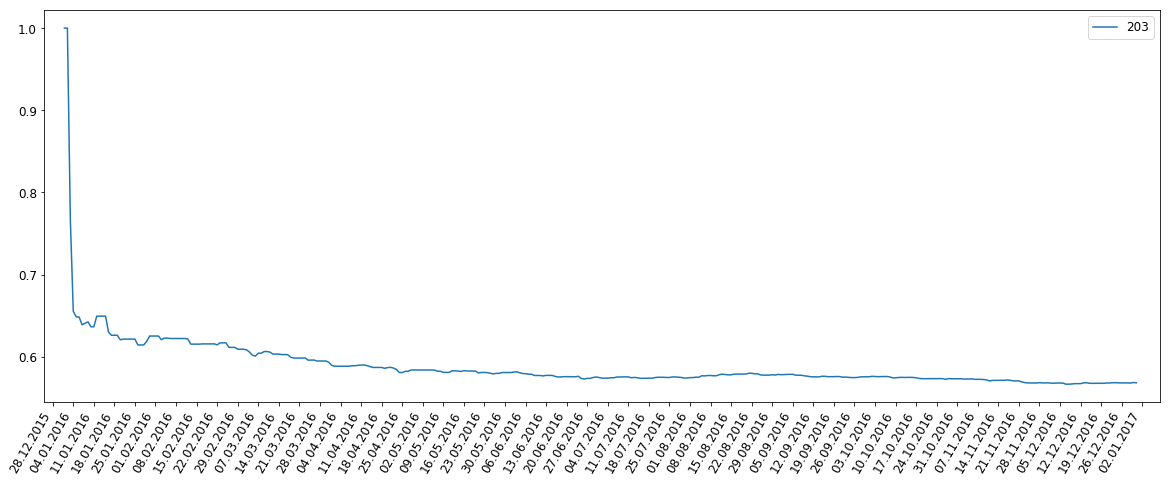

cluster: 203, 20 из 504 новостей:
	 Автомобильная прогулка по льду обернулась трагедией
	 Франция и Бельгия встретили 2016 год неспокойно
	 Закон об ограничении стоимости автомобилей для чиновников и способ его обойти
	 Неуправляемый занос
	 В интернете появилось видео с места аварии на ралли «Дакар»
	 Знаковые предметы и явления, у которых наступивший 2016 год — юбилейный: автомобиль
	 Nvidia представила первый в мире суперкомпьютер для беспилотных машин
	 На границе с Крымом задержан украинский журналист с партией патронов
	 Renault-Nissan анонсировал выпуск машин с автопилотом в ближайшие 4 года
	 Причиной аварии может стать... цвет вашего автомобиля
	 Apple зарегистрировала домены apple.car и apple.auto
	 На ралли Дакар французский гонщик насмерть сбил болельщика
	 Исследование РБК: на чем ездит власть
	 Самые изысканные служебные автомобили российских чиновников
	 Самые дорогие служебные автомобили чиновников
	 На чем летают и плавают кремлевские чиновники
	 Появилась фотография а

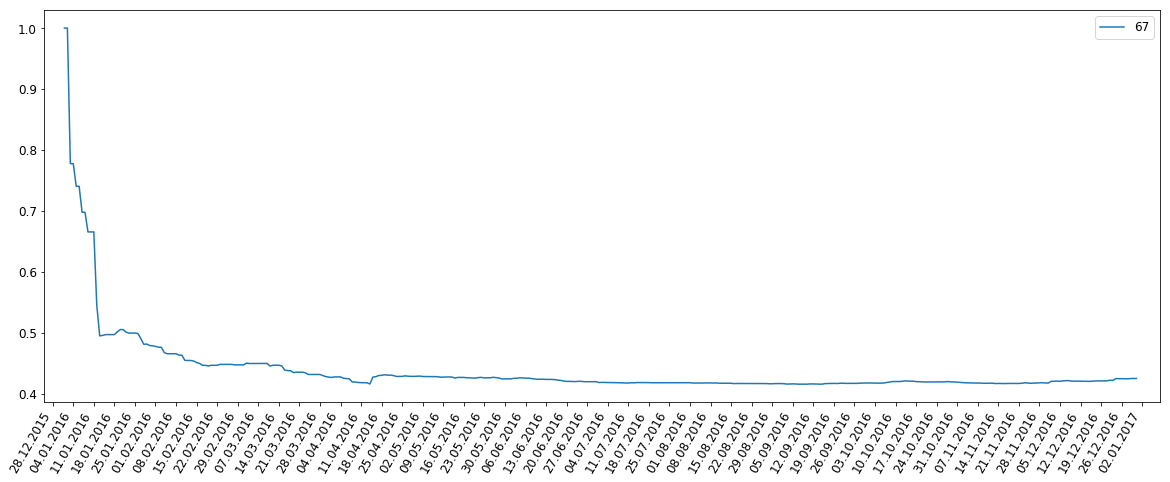

cluster: 67, 20 из 1144 новостей:
	 Путин в тренде
	 Путин назначил Германа Клименко советником по Интернету
	 На каникулах в Сочи Владимир Путин поиграл в хоккей
	 Путин поручил отменить транспортный налог для большегрузов
	 Владимир Путин встретился с участниками Ночной хоккейной лиги
	 Американские СМИ: Вашингтон 15 лет держал в секрете хвалебную речь Клинтона о Путине
	 Путин вручил паспорт гражданина РФ тренеру сборной России по дзюдо
	 Опубликовано видео схватки Путина с самарской дзюдоисткой
	 Отношения с Западом, воссоединение с Крымом и санкции — Владимир Путин дал интервью изданию Bild
	 «Воплощение Бога на земле»
	 Путин назвал главную ошибку России после холодной войны
	 Путин назвал использование спорта в политических целях ошибкой глупых людей
	 «Не претендуем на роль сверхдержавы»
	 Подробный разговор: Путин объяснил немцам роль России, унижение Турции и раздражение Запада
	 Путин и Обама провели телефонные переговоры
	 Президент России и король Иордании обсудили сирийск

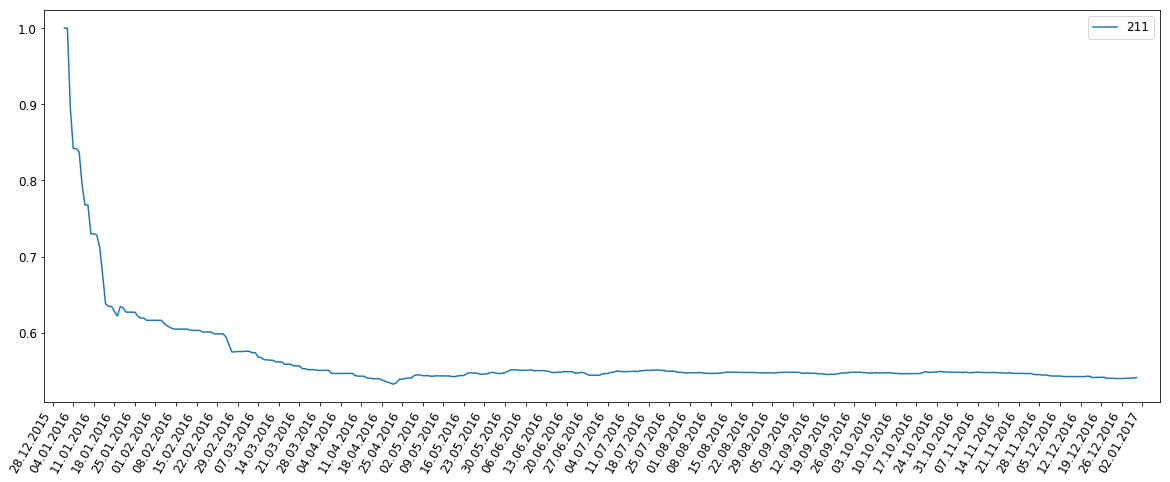

cluster: 211, 20 из 775 новостей:
	 В Башкирии майор МЧС спас Снегурочку и… женился на ней
	 Гимнастка сорвалась из-под купола цирка в Кирове
	 В Сургуте девушка спалила на заправке машину
	 Уткнувшаяся в телефон китаянка упала в канал и утонула
	 В Ессентуках поклонник избил московскую тележурналистку за отказ выйти за него замуж
	 Сын крупного бизнесмена избил в центре Москвы девушку-фотомодель
	 Питон укусил туристку, которая пыталась его поцеловать. Видео
	 В Москве арестовали мажора, которого топ-модель обвинила в изнасиловании
	 Любопытная туристка в Таиланде едва не осталась без носа
	 Преступления на сексуальной почве, совершённые в новогоднюю ночь беженцами, зафиксированы в Швеции
	 Московский полицейский пожаловался на изнасиловавших его проституток
	 В МВД ответили на сообщения об изнасиловании полицейского проститутками
	 Сестры по крови
	 Ученые обнаружили еще один вид сексуальной дискриминации
	 СКР проверит данные о работе проститутки Насти Монпасье в детсаду «Солнышко»


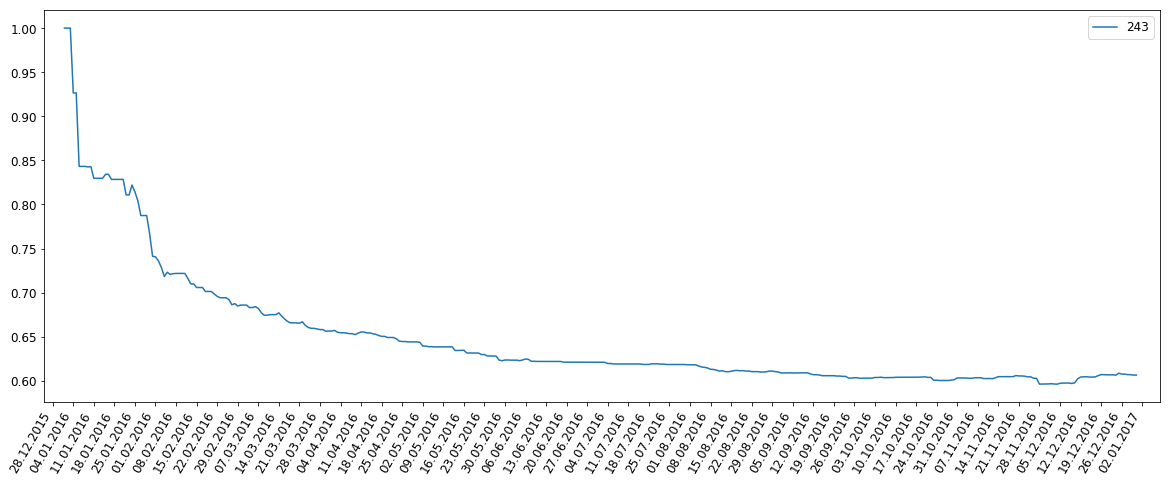

cluster: 243, 20 из 497 новостей:
	 На пятом этапе ралли Africa Eco Race лидирует казахстанец Канат Шагиров
	 Третьяк: Россия готова провести молодежный чемпионат мира по хоккею 2022 года
	 Третий этап "Дакара" остановлен из-за плохой погоды
	 Пятый этап "Дакара" выиграл экипаж Эдуарда Николаева
	 Е.Тудегешева победила в параллельном слаломе на этапе Кубка мира по сноуборду
	 Санный спорт. Семен Павличенко – второй на этапе Кубка мира
	 Лыжи. Сергей Устюгов – третий в общем зачете "Тур де Ски"
	 Айрат Мардеев – третий на 10-м этапе ралли "Дакар"
	 Гараничев взял бронзовую медаль в масс-старте на Кубке мира в Рупольдинге
	 Россиянка Ольга Подчуфарова выиграла спринтерскую гонку на этапе Кубка мира по биатлону в Италии
	 "Это была только мечта для нас": Подчуфарова и Юрлова - на пьедестале
	 Сумасшедший успех Подчуфаровой: биатлонистка стала золотой девушкой в спринте
	 Екатерина Юрлова победила в гонке преследования в Италии
	 Россиянка Екатерина Юрлова выиграла гонку преследования на э

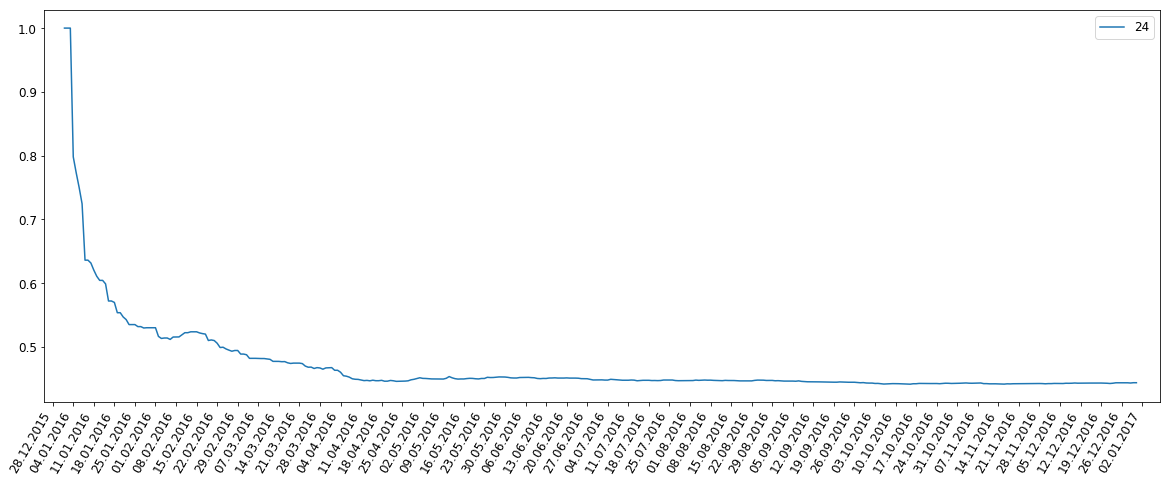

cluster: 24, 20 из 922 новостей:
	 WSJ поместил в «группу риска» руководителей 15 крупнейших компаний мира
	 Bosco назначили единственным поставщиком одежды для «Артека»
	 Компания Coca-Cola опубликовала карту России, включив в нее Крым
	 Гаагский арбитраж начал рассмотрение иска Коломойского к РФ
	 Видеосервис Netflix начал работать в России
	 Swissotel в Москве приостановил работу из-за санкций против Турции
	 Тим Кук оказался самым низкооплачиваемым топ-менеджером Apple
	 Ловушка основателя: как безболезненно передать власть в компании
	 Богатейшие люди мира потеряли $194 млрд за первую неделю 2016 года
	 Форекс-брокеры нашли способ продолжить работать в России
	 Семьи жертв катастрофы А321 решили судиться с владельцем самолета
	 «Укрнафта» обратилась в гаагский арбитраж с иском к России
	 Полина Дерипаска вложила деньги в издания The Village и Furfur
	 Forbes нашел нового долларового миллиардера в России
	 Главным редактором Forbes стал руководитель проекта «Сноб»
	 Хинштейн попрос

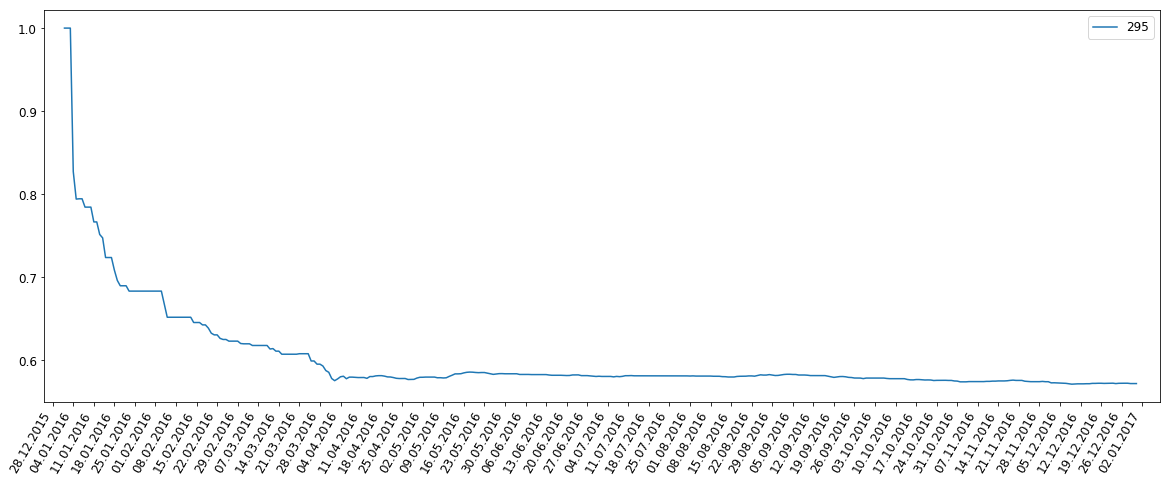

cluster: 295, 20 из 505 новостей:
	 Порошенко размечтался о месте Путина в истории и обрадовался подделке
	 Порошенко заменил на обложке журнала портрет Путина на свой
	 Порошенко опубликовал обложку Economist со своим портретом вместо Путина
	 Порошенко обрадовался попаданию на фальшивую обложку The Economist
	 Порошенко, размечтавшегося о месте Путина, высмеяли пользователи соцсетей
	 Порошенко удалил обложку The Economist, где был пририсован на месте Путина
	 «Это была шутка»: В Киеве прокомментировали «появление» Порошенко на обложке The Economist вместо Путина
	 Фотожаба Порошенко: Киев обиделся на СМИ
	 Playboy Порошенко: президент Украины наконец-то пришел к успеху
	 «Опустился до фотошопа»
	 Место шута: Сеть без чувства юмора ответила Порошенко фотожабами
	 Президент Украины получил от собственной пресс-службы подарок, над которым смеются в Интернете
	 Украинцы на Рождество пожелали Порошенко продать Roshen
	 Пока ты спал
	 В Киеве прошли переговоры Петра Порошенко и Бориса Гры

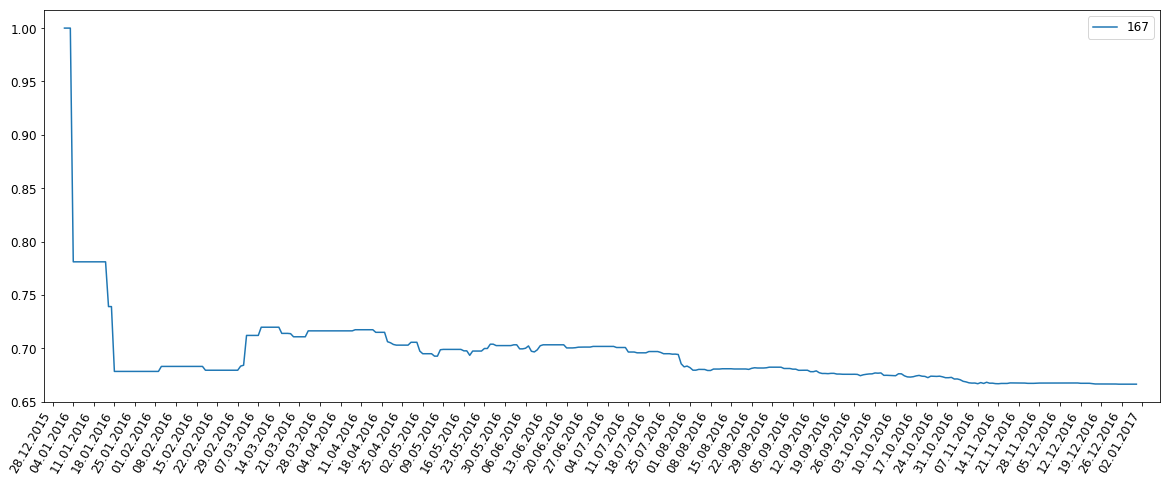

cluster: 167, 20 из 544 новостей:
	 Дональд Трамп предложил американцам выбрать свою дочь вместо Хиллари Клинтон
	 Джеб Буш посчитал Клинтон угрозой для США
	 Статуя Свободы показала средний палец кандидату в президенты США
	 Предвыборные кокусы США: судьбу Клинтон решила брошенная монетка
	 Обама отказался рассматривать Трампа своим преемником
	 Трамп еще не победил, Сандерс пока не проиграл: США ждут "супервторника"
	 Американские гонки: в США начинается ключевой этап президентской кампании
	 "Супервторник" в США: сколько стоит пригласительный в Белый дом
	 Стали известны первые результаты «супервторника» в США
	 "Супервторник" в США: кандидаты подсчитывают голоса
	 "Cупервторник" в США: Клинтон призывает к любви, Трамп готов к охоте
	 Останется сильнейший: лучшим кандидатом в президенты американцы считают Триллари
	 Предвыборная гонка в США: Сандерс обошел Клинтон в штате Мэн
	 В Нью-Йорке прошла демонстрация против агрессивной внешней политики США
	 Трамп «насмешил» Путина лающей К

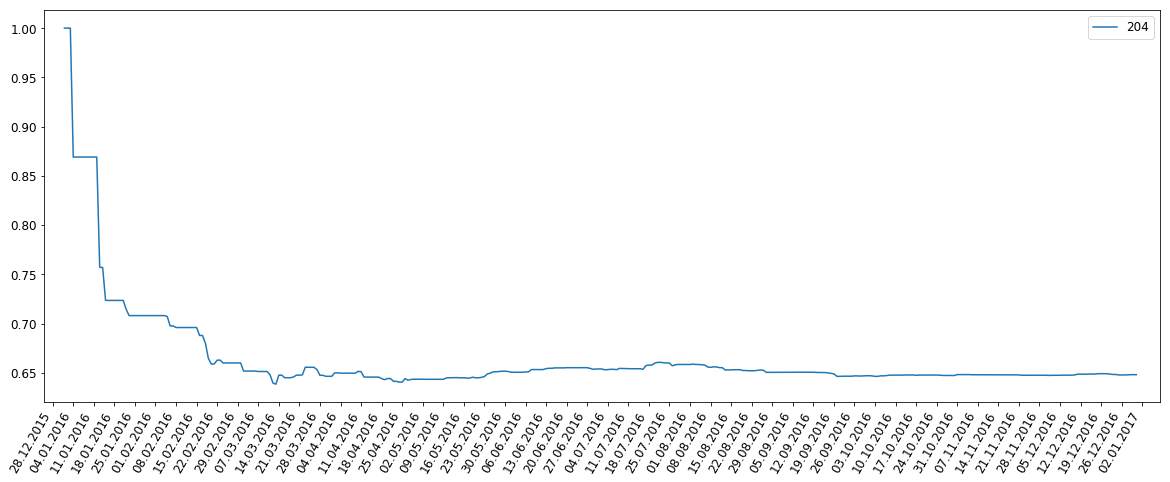

cluster: 204, 20 из 603 новостей:
	 В Пакистане в свадебном автобусе прогремел взрыв: погибли 13 человек
	 В центре Стамбула произошел взрыв. Есть жертвы
	 Взрыв в Стамбуле: пострадали туристы из Германии
	 В посольстве РФ пока нет данных о пострадавших в Стамбуле россиянах
	 Из горящего отеля в Стамбуле спасли более 20 человек
	 Мощный взрыв прогремел в Стамбуле
	 В Джакарте прогремела серия взрывов
	 Атака на Джакарту: ИГ выполнило свои угрозы
	 В Джакарте произошли новые взрывы
	 У посольства РФ в Кабуле взорвали машину: есть жертвы
	 Теракты с жертвами в Египте: взрыв в Гизе, бомбы в Каире
	 МВД Египта: взрыв в Каире организовали "Братья-мусульмане"
	 В Стамбуле прогремел взрыв
	 На строительство стены вокруг Багдада террористы ответили взрывами
	 В турецком Мардине прогремел взрыв
	 Съемки фильма с Джеки Чаном в центре Лондона жители приняли за теракт
	 В Дагестане у поста ГИБДД прогремел взрыв: 2 человека погибли, 17 пострадали
	 Теракт на посту ДПС в Дагестане
	 Жертвами взрыва 

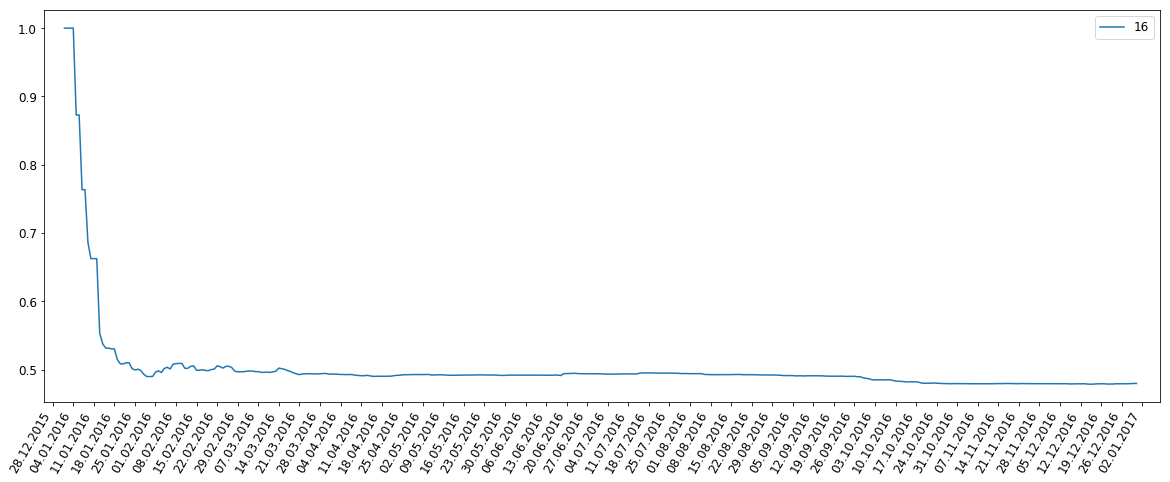

cluster: 16, 20 из 694 новостей:
	 Чичерина выступила перед российскими военными в Сирии
	 США наметили сроки ухода Асада с поста президента Сирии
	 С Асадом или без: может ли закончиться война в Сирии в 2016 году
	 «Спасибо, Россия!»: сирийцы написали на крыше послание для российских летчиков
	 Путин: Россия не претендует на роль супердержавы
	 Мы не претендуем на роль супердержавы: Путин прокомментировал слова Обамы о России
	 Путин прокомментировал возможность предоставления Асаду убежища в России
	 Эрдоган заподозрил Россию в намерении создать карликовое государство в Сирии
	 Кудрин указал на дешевизну операции в Сирии по сравнению с присоединением Крыма
	 Саркози: сирийский кризис без России не решить
	 Чего добилась Россия в Сирии за 100 дней
	 Конашенков: эффективность ВКС РФ в Сирии измеряется не словами, а результатами
	 Баланс сил
	 Москва и Катар договорились искать решение сирийского вопроса
	 Еще один игрок
	 МИД РФ: турецкие укрепления на границе с Сирией могут использова

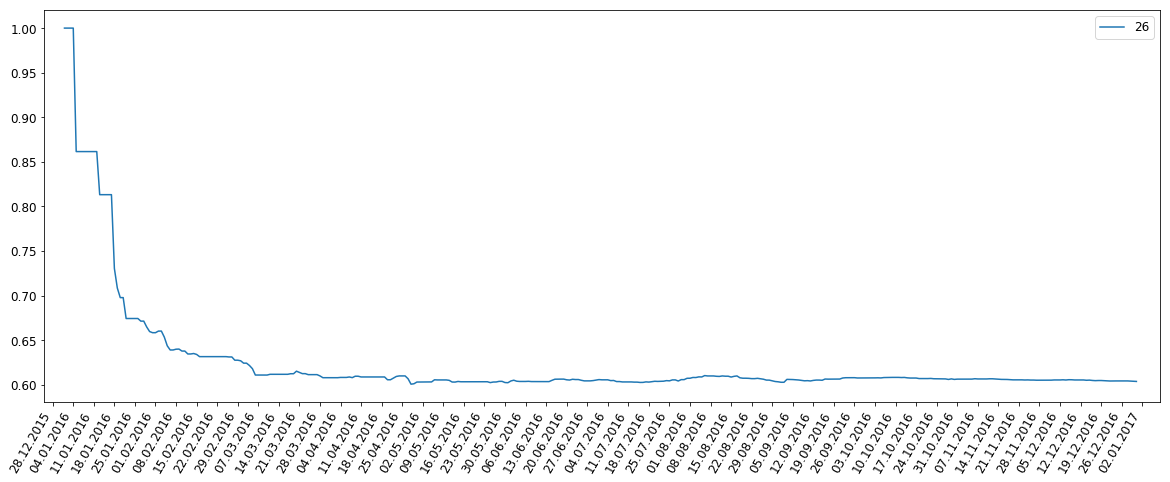

cluster: 26, 20 из 508 новостей:
	 В Таиланде местный житель пытался изнасиловать 8-летнюю россиянку
	 Актер Панин вернул бывшей жене похищенную дочь
	 В детском саду в Татарстане избили девочку-аутиста
	 В Берлине шестеро мигрантов 30 часов насиловали девочку из России
	 Полиция Берлина отрицает факт изнасилования беженцами девочки из русскоязычной семьи
	 Изнасилование 13-летней школьницы в Берлине: полиция на стороне мигрантов
	 В Берлине закрыто дело об изнасиловании русскоязычной девочки
	 В полиции Берлина опровергли сообщения о похищении и изнасиловании 13-летней девочки мигрантами
	 15 лет спустя родители нашли дочь, которую считали умершей
	 Насилие над девочкой в Берлине: российские немцы выйдут к резиденции Меркель
	 Прокуратуру Берлина попросили проверить сюжет об изнасиловании русской девочки
	 Немецкий адвокат хочет засудить авторов репортажа об изнасилованной русской девочке
	 На Урале женщина нашла в детдоме дочь, которую 15 лет считала погибшей
	 В кировском Котельниче

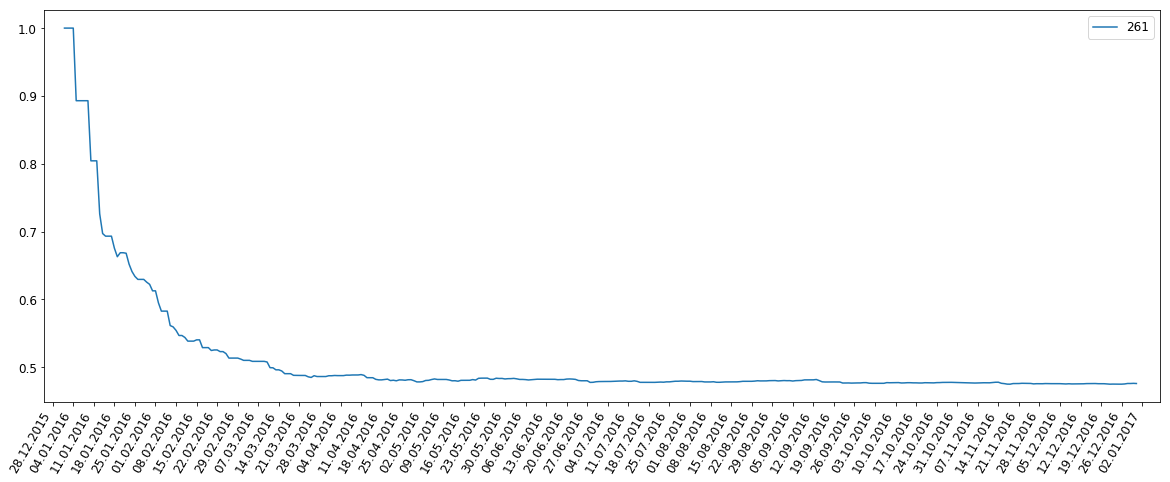

cluster: 261, 20 из 737 новостей:
	 Киргизия заставит австралийца ответить за сравнение колбасы с лошадиным пенисом
	 Глава СК Бастрыкин взял дело белгородского "врача-боксера" на личный контроль
	 В Москве у уборщицы «Газпрома» похитили сумку за 300 тыс. руб.
	 Уровень преступности в России вырос за счет краж и взяток
	 Главу ФСИН по Коми подозревают в причастности к исчезновению трассы
	 Уголовное дело против Евтушенкова прекращено
	 Евтушенков может получить компенсацию за незаконное преследование
	 В Ульяновске студентки жестоко избили сокурсницу и выложили видео в сеть
	 Избитую в ульяновском техникуме сироту забрала к себе социальный педагог
	 Студенток, избивавших сироту, не отчислят до окончания служебной проверки
	 Избиение студентки в Ульяновске: возбуждено дело по статье "Халатность"
	 В орловском перинатальном центре за короткий срок умерли семь младенцев
	 В Ярославле завели дело из-за смерти пациентки после падения с каталки
	 В перинатальном центре в Орле за две недели у

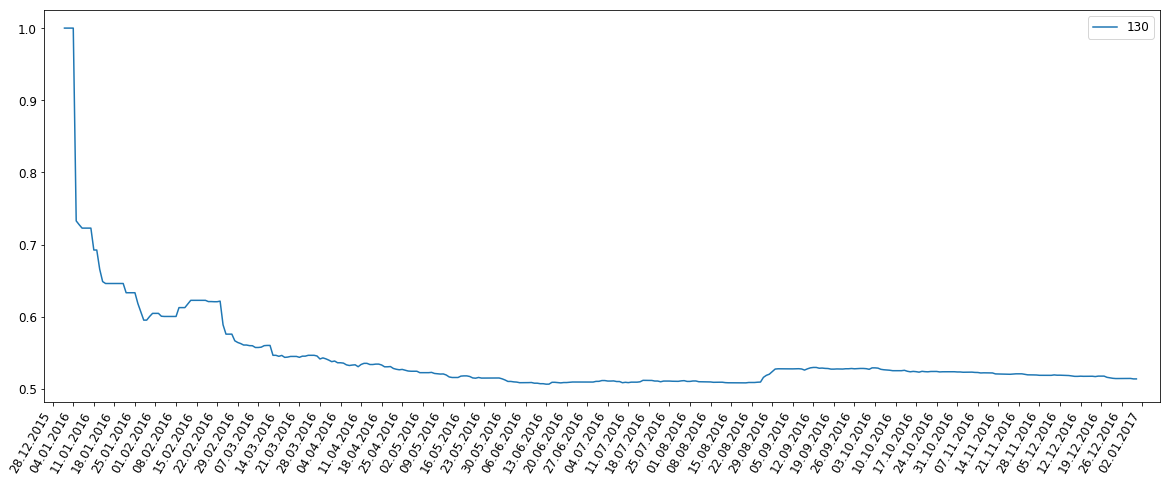

cluster: 130, 20 из 544 новостей:
	 "Триумф" в ВКС. С-400 надежно закрыл небо над Центральной Россией
	 Умер начальник ГРУ Игорь Сергун
	 Российских летчиков в Сирии поздравили звезды российской эстрады
	 Начальник ГРУ Игорь Сергун. 1957 - 2016
	 Игорь Сергун. Жизнь под грифом «секретно»
	 Третье лицо
	 Высокий пост в американской военной академии Вест-Пойнт впервые заняла женщина
	 В 2016 году РВСН запустят 16 межконтинентальных баллистических ракет
	 Новинки года: какая техника пришла в Вооруженные силы РФ в 2015 году
	 "Тополя" и "Ярс" вышли на плановые учения в РВСН
	 В 2016 году Россия завершит обустройство военных баз в Арктике и на Курилах
	 Молодежь бежит из Литвы, спасаясь от воинского призыва
	 Новый облик дракона
	 В России начались испытания ударных дронов, вооруженных гранатометами и огнеметами
	 Новобранцы ЗВО постигают военное ремесло
	 МЧС сократит число чиновников
	 ВДВ РФ: новые разведбаты, новая техника, новые грандиозные планы
	 Российские боевые самолеты за трое су

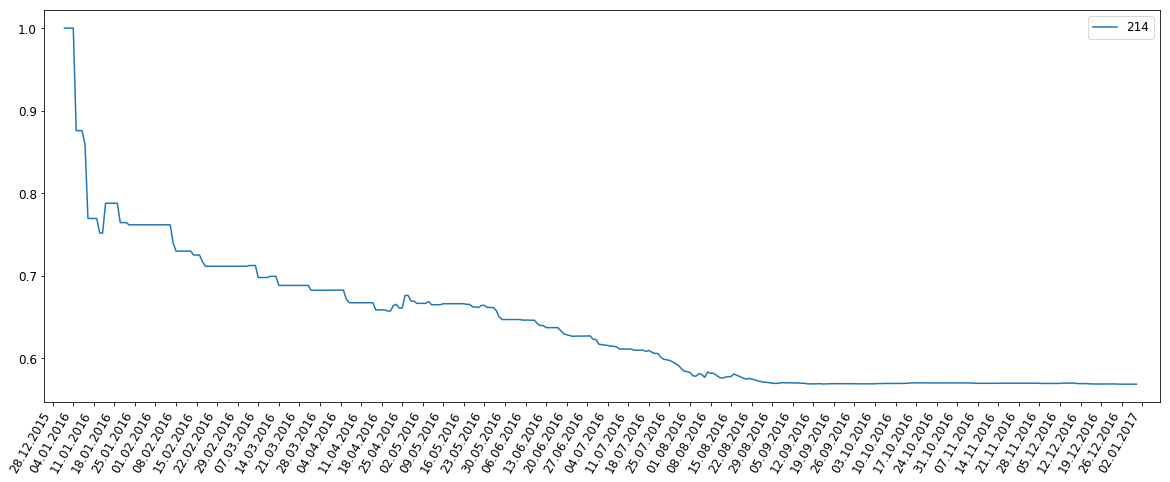

cluster: 214, 20 из 876 новостей:
	 МОК подтвердил результат Ванессы Мэй на Играх в Сочи
	 Плющенко поставил на коньки трехлетнего сына
	 Владимир Путин вручил тренеру по дзюдо Эцио Гамба российский паспорт
	 В аэропорту Шереметьево встретили российских волейболистов
	 Ушла история: Леонид Жаботинский будет похоронен в Запорожье в субботу
	 Как Леонид Жаботинский перехитрил Юрия Власова
	 Ушел из жизни двукратный олимпийский чемпион по тяжелой атлетике Леонид Жаботинский
	 Леонид Жаботинский. Тяжелоатлет, которому не было равных
	 В Сочи в самом разгаре горнолыжный сезон
	 Норвежская бегунья удивила фанатов своими прыжками на тренировке
	 «Секс-символ — это слишком»
	 Юлия Липницкая: от олимпийской славы к новым целям
	 Иван Скобрев завершил спортивную карьеру и не хочет быть тренером
	 Глава "Стопхама" заявил, что не видел ребенка в машине Немова
	 Алексей Немов о конфликте со "СтопХамом": "Призываю всех на дороге относиться с уважением друг к другу"
	 Смена спортивного гражданства: о

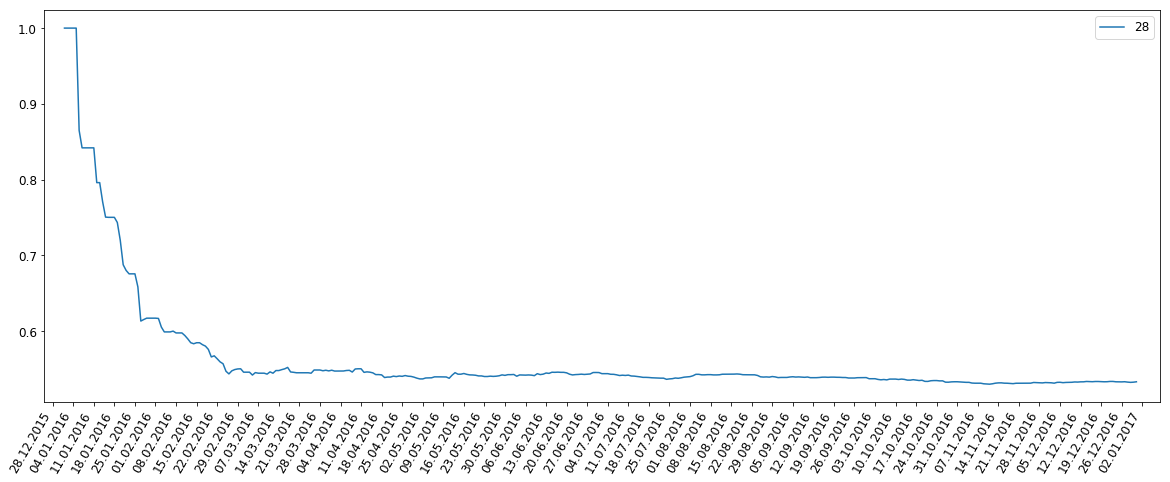

cluster: 28, 20 из 754 новостей:
	 Украинский Google назвал Россию «Мордором», а Лаврова «грустной лошадкой»
	 Любителям Lego предложили заказать себе мини-двойника
	 Клименко разъяснил свои полномочия как советника по интернету
	 Блогер с восьмимиллионной аудиторией снял на видео водопад комментариев
	 Клименко: Дуров перешел границы, он приговаривает Telegram к закрытию
	 Вести.Ru теперь и в Telegram
	 WhatsApp отменил абонентскую плату
	 Мы покупаем, нас покупают: что будет с торговлей через пять лет?
	 В рунете высмеяли Facebook-аккаунт выступающего за запрет соцсетей чиновника
	 Джихад в твоем смартфоне
	 На Twitter «Ленты.ру» подписались более миллиона пользователей
	 В сети ветку от томатов выдали за «органический беспилотник» для веганов
	 Гитлер, Тэтчер, Генри Форд
	 В Госдуме предложили отключить ИГ от интернета
	 Как снизить давление с помощью простого телефона, рассказали ученые
	 Фонд "Общественное мнение": большинство опрошенных читают новости на Вестях.Ru
	 ЦРУ и "Секрет

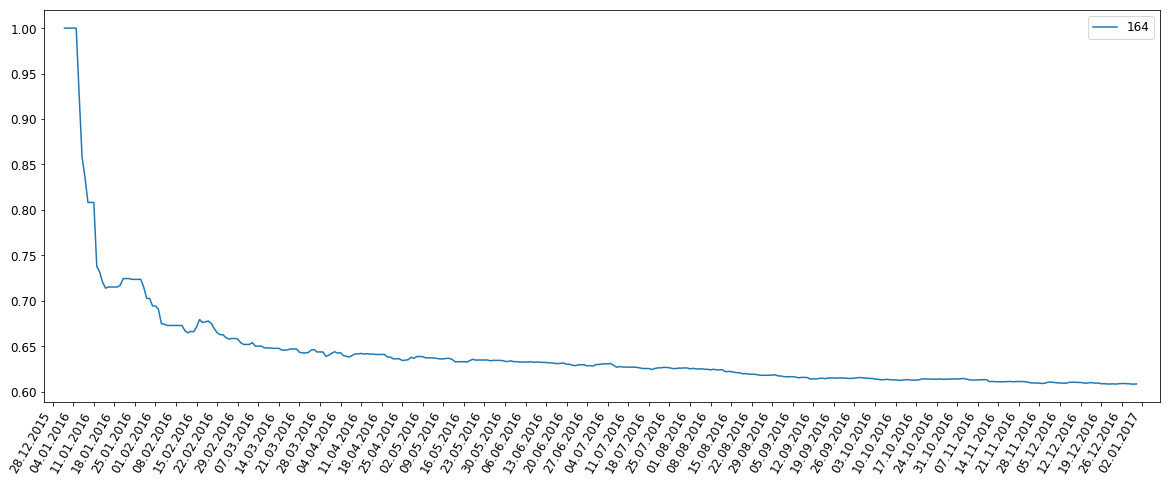

cluster: 164, 20 из 891 новостей:
	 В Сургуте женщина случайно подожгла автозаправочный шланг
	 Новокузнечанин прокатился по городу, стоя на капоте машины
	 Молодой пианист из Италии, опоздав на поезд, стал звездой интернета
	 Американцы сделали пулемет из фейерверков и скотча. Видео
	 "Казнь" российского пилота в киевском клубе организовали для украинских патриотов
	 В Таиланде питон укусил за нос пытавшуюся поцеловать его туристку
	 Дроны в классике
	 Cобытия 2015 года зашифровали в анимированном ролике
	 Создатели проекта об эволюции стандартов красоты взялись за японок
	 Создатели роликов об эволюции стандартов красоты взялись за японок. Видео
	 В Ленобласти лыжник прицепился тросом к электричке
	 Ролик про облитое красками сверло собрал 700 тысяч просмотров за 17 часов
	 В Бразилии краб отказался без боя лезть в кастрюлю
	 Канадец удалил себе глаз и вставил на его место видеокамеру
	 На Аляске горнолыжница отделалась царапинами, сорвавшись с 300-метровой высоты
	 Парапланерист пол

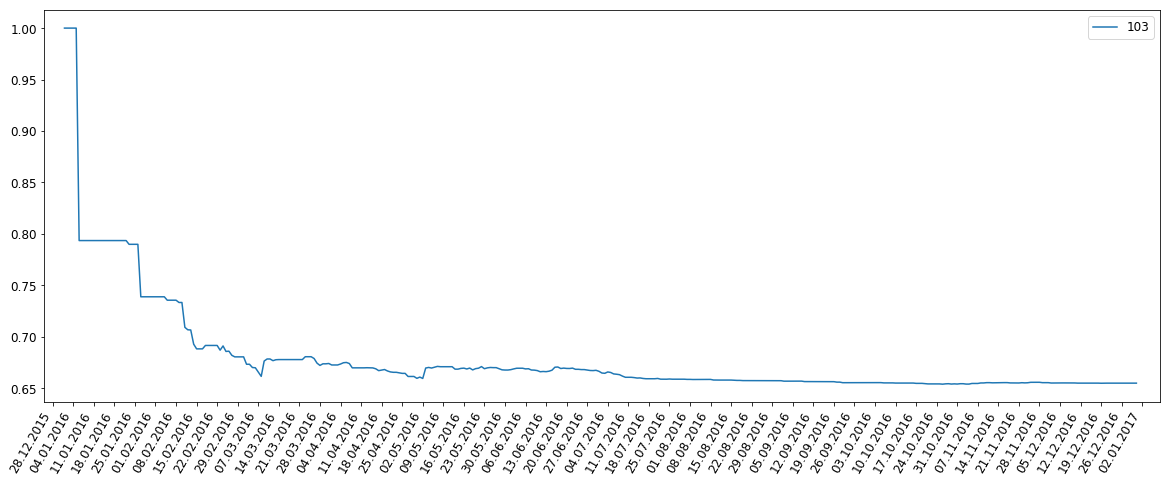

cluster: 103, 20 из 500 новостей:
	 НАТО ответило на новую стратегию нацбезопасности России
	 Генсек НАТО призвал готовиться к гибридной войне
	 Вопрос о вступлении в НАТО разогрел политическую жизнь Черногории до предела
	 НАТО: Россия готовит ядерный удар по Швеции
	 Британия отработает в Иордании мгновенную переброску войск к границам России
	 Армия Великобритании отрабатывает возможный конфликт с Россией
	 Шведов снова пугают российскими военными
	 Польша ждет "агрессивную реакцию" России на расширение НАТО
	 НАТО расширит военное присутствие в Черном и Средиземном морях
	 Министры обороны НАТО одобрили расширение присутствия альянса в Восточной Европе
	 Яценюк назвал срок интеграции армии Украины в НАТО
	 Лавров и Столтенберг составляют повестку Совета Россия-НАТО
	 Медведев: отношения РФ и Запада скатились к временам «холодной войны»
	 Медведев потребовал не допустить «третьей мировой встряски»
	 В Мюнхене люди вышли на улицы, протестуя против политики НАТО
	 Постпред при НАТО по

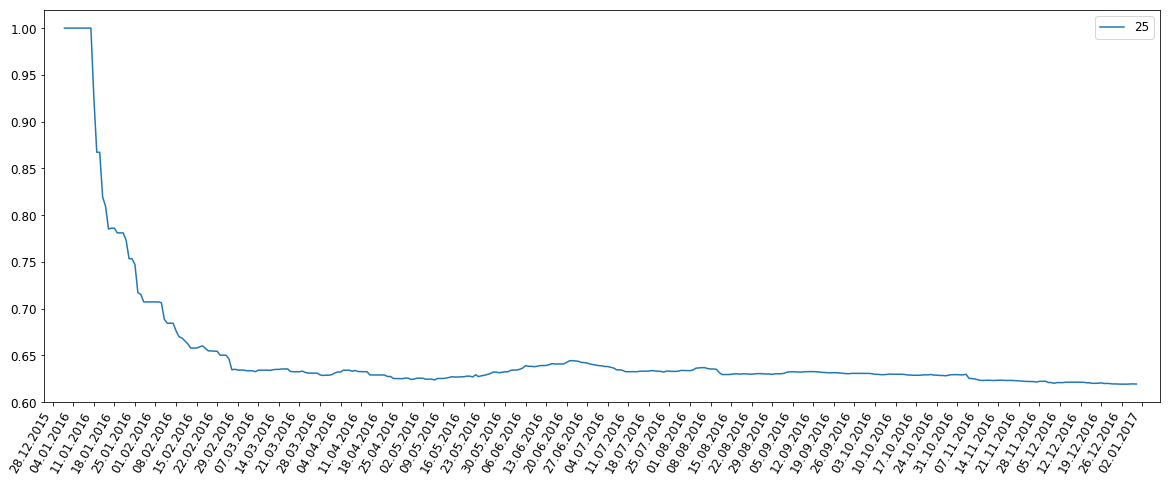

cluster: 25, 20 из 612 новостей:
	 За интервью с Коротышкой Шон Пенн сам может оказаться за решеткой
	 Актер Стивен Сигал получил гражданство Сербии
	 Наркобарона Коротышку посадят в камеру с решеткой, вмонтированной в пол
	 В Петербурге умер актер сериалов "Улицы разбитых фонарей" и "Агент национальной безопасности"
	 Звезда "Диснея" найден мертвым
	 К звезде сериала "Улицы разбитых фонарей" опоздала скорая
	 Адвокат Коротышки обвинил Шона Пенна во лжи
	 Умер Алан Рикман, сыгравший профессора Снегга
	 Умер актер Алан Рикман
	 Актер Алан Рикман скончался от рака
	 «Друзья» воссоединятся для съемок в новой серии
	 Последний аристократ
	 "Все любили Алана": британские артисты скорбят по Рикману
	 Самое главное за ночь: В Лас-Вегасе умер муж Селин Дион, а Нетаньяху рассказал, о чем говорил с Путиным в Москве
	 Мэттью Перри отказался воссоединиться с «Друзьями»
	 Американский актер пойдет под суд за убийство соседа мечом
	 Шон Пенн сожалеет о встрече с мексиканским наркобароном
	 «Симпсоны

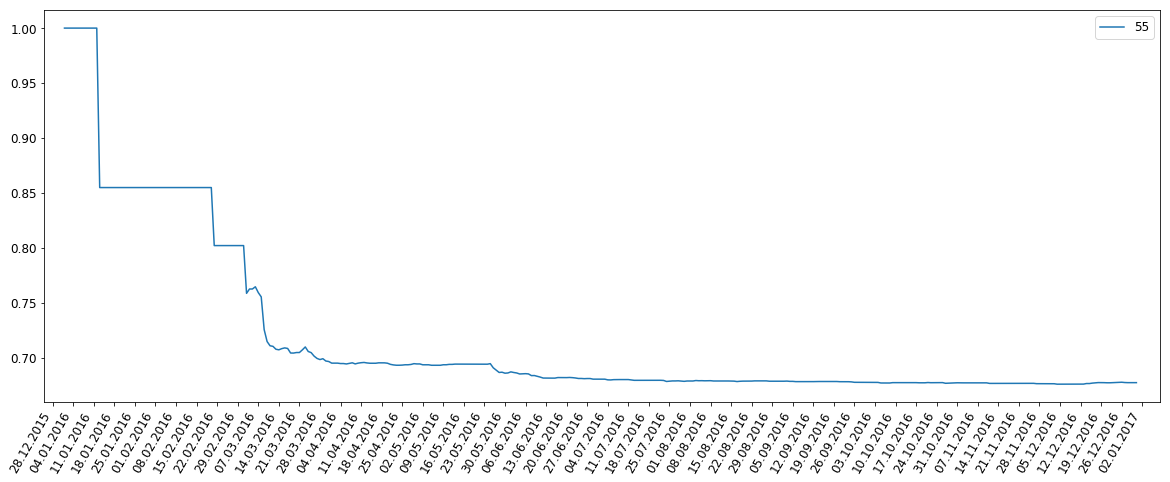

cluster: 55, 20 из 614 новостей:
	 На Троекуровском кладбище открыты памятники погибшим журналистам ВГТРК
	 Захарова: депутатам Европарламента осталось "освоить хоровое пение"
	 Прокурор попросил для Савченко 23 года колонии
	 Прокурор потребовал снять с Савченко обвинение и посадить ее на 23 года
	 Надежда Савченко выступила против обмена себя на россиян
	 Савченко согласна с 23 годами тюрьмы
	 Савченко объявила сухую голодовку
	 Савченко снова объявила сухую голодовку
	 Британия назвала содержание Савченко под стражей незаконным
	 Глава МИД Украины поддержал мирные акции в поддержку Савченко
	 Клинцевич: нападение на посольство РФ спровоцировали власти Украины
	 Савченко продолжает курить и голодать
	 Порошенко просит ЕС и США усилить давление на Россию по делу Савченко
	 Керри увязал исполнение Минских соглашений с освобождением Савченко
	 Керри назвал суд над Савченко нарушением минских соглашений
	 В Совфеде ответили на призыв евродепутата создать «список Савченко»
	 В центре Моск

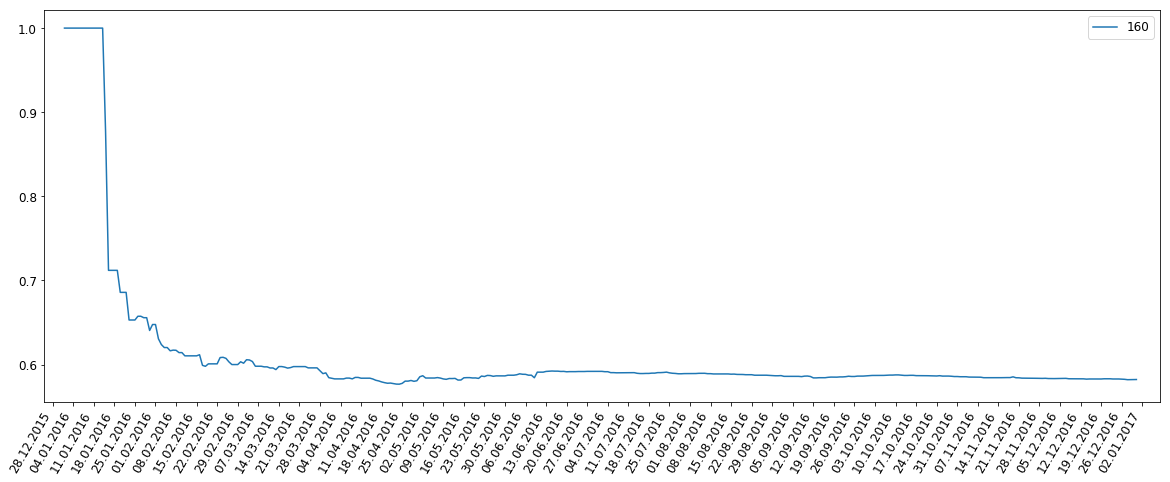

cluster: 160, 20 из 619 новостей:
	 Первое взаимодействие: российские штурмовики прикрыли сирийские истребители
	 Иллюзия эффективности: куда летят российские ВВС
	 Два самолета едва не столкнулись в небе над Москвой из-за трудностей перевода
	 Слава нашла своих героев: в Польше найден сбитый фашистами советский самолет
	 Экзамен на боевую готовность сдают экипажи новейших фронтовых бомбардировщиков в ЮВО
	 Цена независимости
	 Под Красноярском упал МиГ-31. Летчики живы
	 В Красноярском крае разбился МиГ-31
	 Катастрофа МиГ-31: за катапультировавшимися в тайгу летчиками вылетел вертолет
	 ВКС России получили второй новейший военно-транспортный Ил-76МД-90А
	 В Пентагоне заявили о перехвате российским истребителем самолета-разведчика
	 Пентагон возмущен: русский пилот лишил американских шпионов руля и ветрил
	 Крушение МиГ-31: летчики действовали правильно
	 СМИ узнали о переброске в Сирию новейших российских истребителей Су-35C
	 «Коммерсантъ» сообщил о переброске в Сирию новейших росси

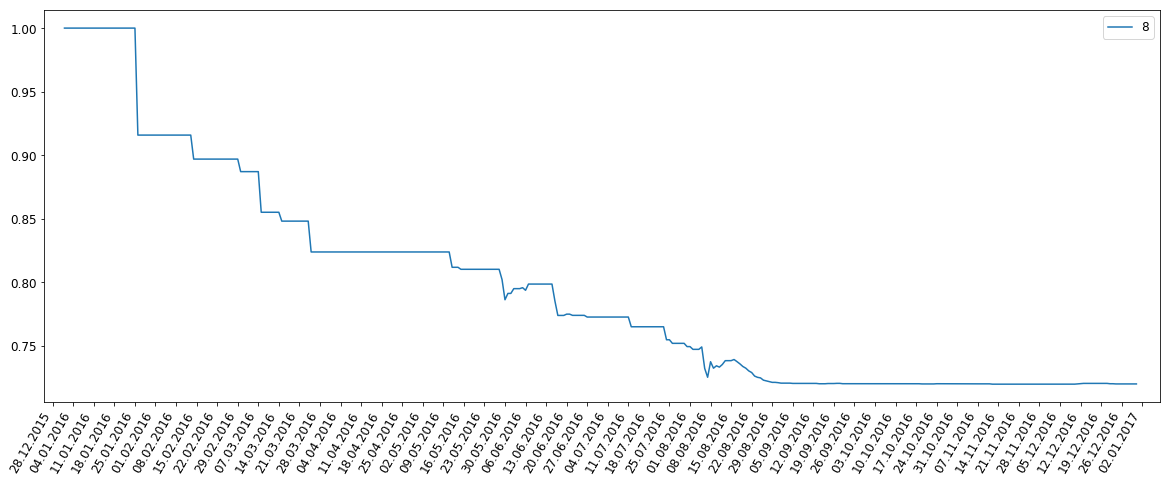

cluster: 8, 20 из 529 новостей:
	 Российские биатлонисты на Кубке мира в Италии взяли «золото» в эстафете «4 по 7,5 километров»
	 Еще одна золотая медаль — в копилке российской сборной
	 Российские "художницы" взяли пять наград Кубка мира
	 Сборная России завоевала три медали на ЧМ по велоспорту на треке
	 Российские борцы взяли еще три золота чемпионата Европы
	 Каниськина лишена серебряной медали ОИ-2012 по спортивной ходьбе
	 Шестерых российских легкоатлетов лишили медалей Олимпиад и ЧМ
	 В Лондоне синхронистка Наталья Ищенко взяла золото в сольной программе
	 Триумфальное выступление российских синхронисток на Чемпионате Европы в Лондоне
	 Биография Алексея Немова
	 Триумф в Берне: российские гимнасты победили на чемпионате Европы-2016
	 Художницы сборной России выиграли четыре золота на Кубке мира
	 Ходоки Каниськина и Кирдяпкин вернули олимпийские медали
	 Россия взяла золото на чемпионате Европы по спортивной гимнастике
	 Российские гимнастки взяли «золото» на мировом первенстве

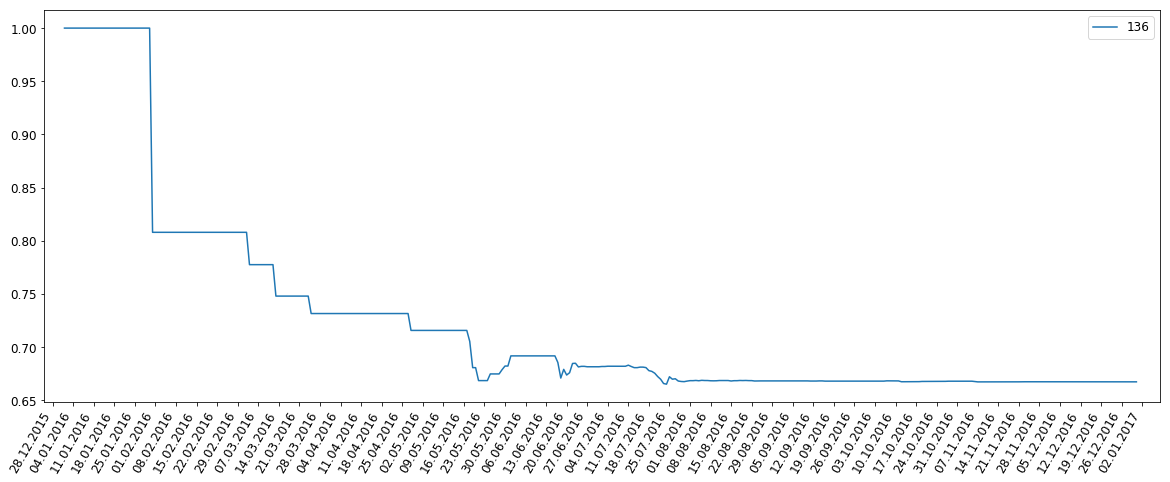

cluster: 136, 20 из 493 новостей:
	 За золотую медаль Олимпиады-2016 заплатят четыре миллиона рублей
	 На Олимпиаде в Рио-де-Жанейро выступит сборная беженцев
	 Мутко спросил IAAF о необходимости «станцевать на столе»
	 Российские ходоки и бегуны лишились лондонских медалей за допинг
	 Жестокая расплата: лучшие легкоатлеты России лишены медалей за допинг
	 Александр Жуков: окончательное решение по легкоатлетам будет принято в июне
	 Четверо российских штангистов дисквалифицированы IWF за допинг
	 Глава МОК не исключил отстранение сборной России от участия в Олимпиаде в Рио
	 Глава МОК не исключает отстранения сборной России от участия в ОИ в Рио
	 WP: Минюст США переходит границы, возомнив себя мировым прокурором
	 Виталий Мутко: у россиян наверняка найдут допинг по пробам Игр-2008
	 При перепроверке проб 14 российских атлетов с ОИ-2008 нашли допинг
	 При повторном анализе 8 российских спортсменов попались на допинге
	 СМИ узнали о положительной допинг-пробе чемпионки ОИ-2012 Татьяны Б

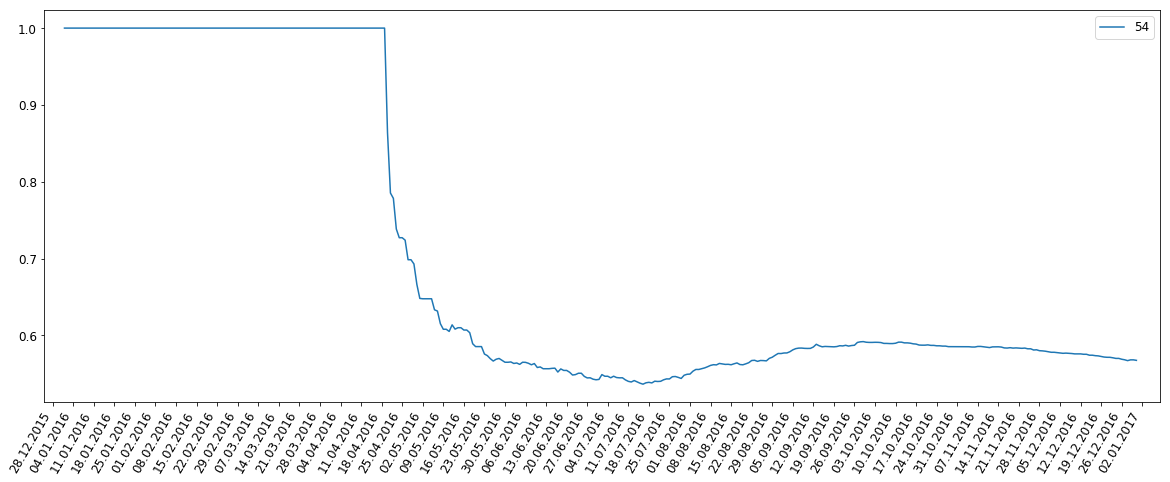

cluster: 54, 20 из 723 новостей:
	 УФАС проверит законность сравнения девушки с курицей в рекламе
	 Замглавы МВД Якутии, обвинённый в попытке изнасилования, пытался покончить с собой
	 Cтроитель Восточного рассказал о своём задержании накануне прямой линии с Путиным
	 Столичные хлебокомбинаты испекут к Пасхе 700 тонн куличей
	 Джефф Монсон пообещал поддерживать юных российских спортсменов
	 Свердловская прокуратура занялась делом пенсионерки, ставшей бомжом по решению суда
	 Горбачёв подтвердил, что находится в больнице
	 В Кубке Голландии по футболу впервые опробуют систему видеоповторов
	 На оцифровку Российской государственной библиотеки уйдёт 300 лет
	 Игорь Николаев выпил за любовь в новом клипе Тимати "Мага"
	 6 самых невероятных танцев с компьютерной графикой
	 Блокадников с 9 Мая поздравят шампанским, пледами и бесплатными стрижками
	 Правила жизни Дмитрия Киселёва в понятных гифках
	 Президент ГЛОНАСС: Российскую систему признал весь мир
	 Писательницу Людмилу Улицкую облили з

In [139]:
for c_label, c_news in medium_clusters.items():
    compute_for_cluster(c_news, c_label)